In [1]:
import os, pickle, warnings, itertools
from pathlib import Path
from functools import partial 

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)
warnings.simplefilter(action='ignore', category=FutureWarning)


%load_ext autoreload
%autoreload 1
%aimport salford_datasets.salford, salford_datasets.salford_raw, transformer_experiment.utils.embeddings, transformer_experiment.utils.finetuning, transformer_experiment.utils.shallow_classifiers, transformer_experiment.utils.plots
%aimport acd_experiment.base_dataset, acd_experiment.salford_adapter, acd_experiment.models, acd_experiment.sci, acd_experiment.systematic_comparison

from salford_datasets.salford import SalfordData, SalfordFeatures, SalfordPrettyPrint, SalfordCombinations
from acd_experiment.salford_adapter import SalfordAdapter

In [2]:
class Notebook:
    DATA_DIR = Path('data/Salford')
    CACHE_DIR = Path('data/cache')
    IMAGE_DIR = Path('images/shallow')
    SYSTEMATIC_COMPARISON_DIR = Path('data/systematic_comparison/')
    RE_DERIVE = False

In [3]:
from transformer_experiment.utils.shallow_classifiers import load_salford_dataset, get_train_test_indexes

SAL = load_salford_dataset(Notebook.RE_DERIVE, Notebook.DATA_DIR)
SAL_TRAIN_IDX, SAL_TEST_IDX, SAL_TEST_UNSEEN_IDX, SAL_TEST_IS_UNSEEN = get_train_test_indexes(SAL)

2023-04-16 11:17:59,717 [INFO] Loading processed dataset


In [4]:
from acd_experiment.models import Estimator_L1Regression, Estimator_LinearSVM, Estimator_LightGBM, Estimator_L2Regression, Estimator_ElasticNetRegression, Estimator_XGBoost

FEATURE_GROUP_CORRESPONDENCE = {
    'news': 'news',
    'with_phenotype': 'news_with_phenotype',
    'with_labs': 'with_labs',
    'with_services': 'with_notes_labs_and_hospital'
}

PRETTY_PRINT_FEATURE_GROUPS = {
    'Reference': 'Reference',
    'news': 'Vitals',
    'with_phenotype': '& Obs',
    'with_labs': '& Labs',
    'with_services': '& Services',
}

PRETTY_PRINT_ESTIMATORS = dict(
    NEWS2='NEWS2',
    LogisticRegression='LR',
    L1Regression='LR-L1',
    L2Regression='LR-L2',
    ElasticNetRegression='LR-EN',
    XGBoost='XGBoost',
    LightGBM='LightGBM',
    LinearSVM='LinearSVM'
)

PRETTY_PRINT_FEATURE_NAMES = {
    k:(
        v.replace('First Blood ', '')
        .replace('First Obs ', '')
        .replace('Emergency Department', 'ED')
    )
    for k,v in SalfordPrettyPrint.items()
}

ESTIMATORS = {_._name: _ for _ in [
    Estimator_LightGBM,
    Estimator_L2Regression,
    Estimator_XGBoost,
    Estimator_LinearSVM,
    Estimator_L1Regression,
    Estimator_ElasticNetRegression,
]}

STUDY_GRID = list(itertools.product(ESTIMATORS.keys(), FEATURE_GROUP_CORRESPONDENCE.keys()))

## Model Training

In [5]:
from acd_experiment.salford_adapter import SalfordAdapter
from sklearn.calibration import CalibratedClassifierCV
import optuna
from acd_experiment.systematic_comparison import get_xy, PipelineFactory

def run_pretuned(sal, estimator_name, feature_group_name, cv_jobs=4, explain_models=['LightGBM', 'L2Regression'], feature_columns=None, outcome_within=1):
    params = optuna.load_study(
        study_name =f'{estimator_name}_None_Within-1_{FEATURE_GROUP_CORRESPONDENCE[feature_group_name]}', storage=f'sqlite:///{Notebook.SYSTEMATIC_COMPARISON_DIR}/{estimator_name}.db'
    ).best_params
    
    estimator = ESTIMATORS[estimator_name]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        X, y = SalfordAdapter(sal).xy(
            x=feature_columns or SalfordCombinations[feature_group_name],
            imputation = estimator._requirements['imputation'],
            fillna = estimator._requirements['fillna'],
            ordinal_encoding = estimator._requirements['ordinal'],
            onehot_encoding = estimator._requirements['onehot'],
            outcome_within=outcome_within
        )
    X_train, y_train = SalfordAdapter(X.loc[SAL_TRAIN_IDX]), y.loc[SAL_TRAIN_IDX].values

    pipeline_factory = PipelineFactory(
        estimator=estimator, resampler=None, X_train=X_train, y_train=y_train,
    )

    model = CalibratedClassifierCV(
        pipeline_factory(**params), cv=cv_jobs, method="isotonic", n_jobs=cv_jobs,
    ).fit(X_train, y_train)


    y_pred_proba = model.predict_proba(X.loc[SAL_TEST_IDX])[:,1]
    y_pred_proba_unseen = y_pred_proba[SAL_TEST_IS_UNSEEN]

    explanations = None
    if estimator_name in explain_models:
        explanations = estimator.explain_calibrated(
            model, X_train, SalfordAdapter(X.loc[SAL_TEST_IDX]), cv_jobs=cv_jobs
        )

    return y_pred_proba, y_pred_proba_unseen, explanations, model
    
if Notebook.RE_DERIVE:
    RESULTS = {}
    for estimator_name, feature_group_name in (pbar := tqdm(STUDY_GRID)):
        pbar.set_description(f'Training {estimator_name} on {feature_group_name}')
        RESULTS[(PRETTY_PRINT_ESTIMATORS[estimator_name], PRETTY_PRINT_FEATURE_GROUPS[feature_group_name])] = run_pretuned(SAL, estimator_name, feature_group_name)

        with open(Notebook.CACHE_DIR/'shallow_results_2.bin', 'wb') as file:
            pickle.dump(RESULTS, file)
else:
    with open(Notebook.CACHE_DIR/'shallow_results_2.bin', 'rb') as file:
            RESULTS = pickle.load(file)

In [6]:
from transformer_experiment.utils.shallow_classifiers import get_discriminative_metrics
Y_TRUES = {
    'Complete': SAL.CriticalEvent.loc[SAL_TEST_IDX],
    'Unseen': SAL.CriticalEvent.loc[SAL_TEST_UNSEEN_IDX],
}
def get_full_metrics_tables(results):
    metrics = {
        'Complete': [],
        'Unseen': [],
    }
    for (estimator_name, feature_group_name), y_preds in results.items():
        for y_pred_proba, (y_true_name, y_true) in zip(y_preds, Y_TRUES.items()):
            metrics[y_true_name].append(dict(
                Estimator = estimator_name,
                Features = feature_group_name,
            ) | get_discriminative_metrics(
                y_true, y_pred_proba
            ))
    
    for y_true_name, y_true in Y_TRUES.items():
        metrics[y_true_name].append(dict(
            Estimator='NEWS2',
            Features='Reference'
        ) | get_discriminative_metrics(
            y_true, SAL.NEWS_Score_Admission.loc[y_true.index]
        ))

    return {
        y_true_name: pd.DataFrame(metric_list) for y_true_name, metric_list in metrics.items()
    }

if Notebook.RE_DERIVE:
    METRICS = get_full_metrics_tables(RESULTS)
    with open(Notebook.CACHE_DIR/'shallow_results_2_metrics.bin', 'wb') as file:
        pickle.dump(METRICS, file)
else:
    with open(Notebook.CACHE_DIR/'shallow_results_2_metrics.bin', 'rb') as file:
            METRICS = pickle.load(file)

## Transformer Results

In [7]:
def load_transformer_results():
    with open(Notebook.CACHE_DIR/'transformer_shallow_results_ensemble.bin', 'rb') as file:
        shallow_results_ensemble = pickle.load(file)
    with open(Notebook.CACHE_DIR/'transformer_shallow_results_embonly.bin', 'rb') as file:
        shallow_results_joint = pickle.load(file)
    with open(Notebook.CACHE_DIR/'transformer_finetuning_results.bin', 'rb') as file:
        finetuning_results = pickle.load(file)

    pretty_print_ensembles = PRETTY_PRINT_ESTIMATORS | {'LightGBM': 'LGBM'}
    shallow_results = {
        (PRETTY_PRINT_ESTIMATORS[key[0]], key[1]): value for key, value in shallow_results_joint.items()
    }| {
        (f'{pretty_print_ensembles[key[0]]}-Ensemble', key[2]): value for key, value in shallow_results_ensemble.items()
        if key[0] == key[1]
    }
    
    return shallow_results, finetuning_results

TRANSF_RESULTS_SHALLOW, TRANSF_RESULTS_DEEP = load_transformer_results()
TRANSF_METRICS_SHALLOW, TRANSF_METRICS_DEEP = get_full_metrics_tables(TRANSF_RESULTS_SHALLOW), get_full_metrics_tables(TRANSF_RESULTS_DEEP)

In [8]:
def get_select_transformer_results(results_shallow, results_deep):
    shallow_choices = [('LightGBM', 'BioClinicalBert'), ('LR-L2', 'BioClinicalBert'), ('LGBM-Ensemble', 'BioClinicalBert')]
    deep_choices = [('BioClinicalBert', 'All'), ('PubMedBert', 'All'), ('Bert', 'All')]
    shallow_choices = {_:results_shallow[_] for _ in shallow_choices}
    deep_choices = {_: results_deep[_] for _ in deep_choices}
    return shallow_choices | deep_choices

TRANSF_RESULTS_SELECT = get_select_transformer_results(TRANSF_RESULTS_SHALLOW, TRANSF_RESULTS_DEEP)
TRANSF_METRICS_SELECT = get_full_metrics_tables(TRANSF_RESULTS_SELECT)

In [41]:
TRANSF_METRICS_SELECT['Unseen']

,Estimator,Features,AUROC,AUROC_Upper,AUROC_Lower,AP,AP_Upper,AP_Lower
1,LR-L2,BioClinicalBert,0.912348,0.919447,0.905388,0.564169,0.588532,0.539163
2,LGBM-Ensemble,BioClinicalBert,0.934691,0.942291,0.929295,0.638287,0.665474,0.617732
3,BioClinicalBert,All,0.962031,0.967579,0.957468,0.802016,0.823167,0.780094
4,PubMedBert,All,0.934844,0.942499,0.925430,0.806790,0.821743,0.791522
5,Bert,All,0.961946,0.967476,0.956352,0.830896,0.848044,0.812599
6,NEWS2,Reference,0.737202,0.749553,0.719892,0.167346,0.183019,0.152789


## Metrics

### Summary Table

In [11]:
def summary_metrics_select_estimators(metrics, estimators=['LightGBM', 'LR-L2']):
    df = pd.DataFrame(dict(
            Metric=metric,
            Estimator=_['Estimator'],
            Features=_['Features'],
            Value=f"{_[metric]:.3f}",
            Dataset=dataset
        ) for dataset, df in metrics.items() for _ in df[df.Estimator.isin(estimators)].to_dict(orient='records') for metric in ('AUROC', 'AP')
    ).sort_values(['Metric', 'Estimator', 'Dataset']).set_index(['Metric', 'Estimator', 'Dataset', 'Features']).unstack()['Value'][list(PRETTY_PRINT_FEATURE_GROUPS.values())[1:]]
    return df

result_metrics_summary = summary_metrics_select_estimators(METRICS)
result_metrics_summary

Features                  Vitals  & Obs & Labs & Services
Metric Estimator Dataset                                 
AP     LR-L2     Complete  0.140  0.248  0.274      0.345
                 Unseen    0.176  0.304  0.327      0.408
       LightGBM  Complete  0.241  0.392  0.468      0.499
                 Unseen    0.301  0.462  0.545      0.577
AUROC  LR-L2     Complete  0.710  0.816  0.835      0.855
                 Unseen    0.709  0.820  0.840      0.862
       LightGBM  Complete  0.794  0.877  0.908      0.915
                 Unseen    0.802  0.886  0.917      0.925

In [17]:
#print(result_metrics_summary.to_latex(bold_rows=True, escape=False, column_format='lll|cccc', multirow=True, formatters=[lambda x: f'${x}$' for _ in range(result_metrics_summary.shape[1])]))

In [13]:
def summary_metrics_transformers(metrics_shallow, metrics_deep, estimators=['LR-L2', 'LGBM-Ensemble'], transformers=['BioClinicalBert', 'PubMedBert', 'Bert']):
    shallow_rows = [dict(
            Metric=metric,
            Estimator=_['Estimator'],
            Transformer=_['Features'],
            Value=f"{_[metric]:.3f}",
            Dataset=dataset
        ) 
        for dataset, df in metrics_shallow.items() 
        for _ in df[df.Estimator.isin(estimators) & df.Features.isin(transformers)].to_dict(orient='records') 
        for metric in ('AUROC', 'AP')
    ]

    deep_rows = [dict(
            Metric=metric,
            Estimator='WFine-Tuning',
            Transformer=_['Estimator'],
            Value=f"{_[metric]:.3f}",
            Dataset=dataset
        ) for dataset, df in metrics_deep.items() for _ in df[df.Estimator.isin(transformers) & (df.Features=='All')].to_dict(orient='records') for metric in ('AUROC', 'AP')
    ]
    
    df = pd.DataFrame(shallow_rows + deep_rows).sort_values(['Metric', 'Estimator', 'Dataset']).set_index(['Metric', 'Estimator', 'Dataset', 'Transformer']).unstack()['Value']
    return df

summary_metrics_transformers = summary_metrics_transformers(TRANSF_METRICS_SHALLOW, TRANSF_METRICS_DEEP)
summary_metrics_transformers

Transformer                     Bert BioClinicalBert PubMedBert
Metric Estimator     Dataset                                   
AP     LGBM-Ensemble Complete  0.549           0.557      0.563
                     Unseen    0.630           0.638      0.642
       LR-L2         Complete  0.488           0.481      0.491
                     Unseen    0.571           0.564      0.573
       WFine-Tuning  Complete  0.771           0.744      0.748
                     Unseen    0.831           0.802      0.807
AUROC  LGBM-Ensemble Complete  0.922           0.927      0.928
                     Unseen    0.931           0.935      0.936
       LR-L2         Complete  0.900           0.902      0.906
                     Unseen    0.913           0.912      0.915
       WFine-Tuning  Complete  0.955           0.955      0.927
                     Unseen    0.962           0.962      0.935

In [15]:
#print(summary_metrics_transformers.to_latex(bold_rows=True, escape=False, column_format='lll|ccc', multirow=True, formatters=[lambda x: f'${x}$' for _ in range(summary_metrics_transformers.shape[1])]))

### Detailed Tables

In [96]:
def detailed_metrics_all_estimators(metrics, index=['Features', 'Estimator']):
    df = pd.DataFrame(dict(
            Dataset=dataset,
            Metric=metric,
            Estimator=_['Estimator'],
            Features=_['Features'],
            Summary = f'{_[metric]:.4f} ({_[metric+"_Lower"]:.4f}-{_[metric + "_Upper"]:.4f})'
        ) for dataset, df in metrics.items() for _ in df.to_dict(orient='records') for metric in ('AUROC', 'AP')
    ).pivot(index=index, columns=['Metric', 'Dataset'], values='Summary')

    return df[['AUROC', 'AP']]

result_metrics_long = detailed_metrics_all_estimators(METRICS).loc[PRETTY_PRINT_FEATURE_GROUPS.values()]
result_metrics_long

Metric                                 AUROC                          \
Dataset                             Complete                  Unseen   
Features   Estimator                                                   
Reference  NEWS2      0.7340 (0.7213-0.7471)  0.7372 (0.7199-0.7496)   
Vitals     LR-EN      0.7093 (0.6953-0.7198)  0.7083 (0.6931-0.7231)   
           LR-L1      0.7088 (0.6947-0.7192)  0.7078 (0.6928-0.7218)   
           LR-L2      0.7099 (0.6959-0.7200)  0.7092 (0.6938-0.7238)   
           LightGBM   0.7942 (0.7821-0.8080)  0.8021 (0.7879-0.8146)   
           LinearSVM  0.7512 (0.7397-0.7656)  0.7541 (0.7354-0.7678)   
           XGBoost    0.7949 (0.7835-0.8072)  0.8036 (0.7885-0.8159)   
& Obs      LR-EN      0.8166 (0.8054-0.8237)  0.8212 (0.8125-0.8310)   
           LR-L1      0.8159 (0.8044-0.8235)  0.8218 (0.8130-0.8312)   
           LR-L2      0.8158 (0.8046-0.8234)  0.8198 (0.8109-0.8298)   
           LightGBM   0.8773 (0.8690-0.8830)  0.8857 (0.8761-0.8947)   
           LinearSVM  0.8099 (0.7987-0.8187)  0.8154 (0.8049-0.8249)   
           XGBoost    0.8742 (0.8672-0.8805)  0.8825 (0.8752-0.8898)   
& Labs     LR-EN      0.8363 (0.8260-0.8445)  0.8410 (0.8315-0.8492)   
           LR-L1      0.8375 (0.8277-0.8458)  0.8436 (0.8342-0.8516)   
           LR-L2      0.8354 (0.8252-0.8439)  0.8398 (0.8301-0.8481)   
           LightGBM   0.9079 (0.9018-0.9129)  0.9168 (0.9100-0.9249)   
           LinearSVM  0.8361 (0.8261-0.8433)  0.8398 (0.8278-0.8483)   
           XGBoost    0.9043 (0.8976-0.9098)  0.9125 (0.9046-0.9206)   
& Services LR-EN      0.8556 (0.8459-0.8632)  0.8624 (0.8540-0.8707)   
           LR-L1      0.8552 (0.8458-0.8629)  0.8622 (0.8539-0.8707)   
           LR-L2      0.8548 (0.8454-0.8625)  0.8616 (0.8532-0.8703)   
           LightGBM   0.9150 (0.9087-0.9200)  0.9249 (0.9180-0.9331)   
           LinearSVM  0.8514 (0.8418-0.8592)  0.8581 (0.8482-0.8664)   
           XGBoost    0.9087 (0.9019-0.9140)  0.9179 (0.9111-0.9259)   

Metric                                    AP                          
Dataset                             Complete                  Unseen  
Features   Estimator                                                  
Reference  NEWS2      0.1400 (0.1301-0.1537)  0.1673 (0.1528-0.1830)  
Vitals     LR-EN      0.1383 (0.1261-0.1540)  0.1735 (0.1572-0.1911)  
           LR-L1      0.1396 (0.1273-0.1552)  0.1753 (0.1592-0.1927)  
           LR-L2      0.1397 (0.1270-0.1543)  0.1759 (0.1594-0.1932)  
           LightGBM   0.2413 (0.2211-0.2587)  0.3008 (0.2757-0.3249)  
           LinearSVM  0.1528 (0.1400-0.1684)  0.1947 (0.1750-0.2151)  
           XGBoost    0.2425 (0.2198-0.2629)  0.3051 (0.2821-0.3293)  
& Obs      LR-EN      0.2425 (0.2184-0.2642)  0.3021 (0.2762-0.3216)  
           LR-L1      0.2364 (0.2132-0.2561)  0.3000 (0.2753-0.3182)  
           LR-L2      0.2476 (0.2227-0.2706)  0.3044 (0.2790-0.3245)  
           LightGBM   0.3924 (0.3666-0.4144)  0.4624 (0.4372-0.4868)  
           LinearSVM  0.2138 (0.1944-0.2307)  0.2612 (0.2391-0.2805)  
           XGBoost    0.3676 (0.3433-0.3873)  0.4333 (0.4088-0.4574)  
& Labs     LR-EN      0.2669 (0.2425-0.2885)  0.3222 (0.2938-0.3476)  
           LR-L1      0.2886 (0.2622-0.3121)  0.3479 (0.3210-0.3733)  
           LR-L2      0.2738 (0.2489-0.2966)  0.3266 (0.2979-0.3526)  
           LightGBM   0.4677 (0.4462-0.4918)  0.5453 (0.5198-0.5709)  
           LinearSVM  0.2394 (0.2190-0.2585)  0.2785 (0.2543-0.2990)  
           XGBoost    0.4577 (0.4342-0.4760)  0.5321 (0.5101-0.5599)  
& Services LR-EN      0.3571 (0.3269-0.3834)  0.4207 (0.3926-0.4423)  
           LR-L1      0.3579 (0.3276-0.3842)  0.4212 (0.3929-0.4430)  
           LR-L2      0.3450 (0.3156-0.3713)  0.4079 (0.3804-0.4301)  
           LightGBM   0.4987 (0.4728-0.5182)  0.5773 (0.5546-0.6030)  
           LinearSVM  0.2683 (0.2482-0.2887)  0.3149 (0.2910-0.3363)  
           XGBoost    0.4812 (0.4558-0.5048)  0.5593 (0.5356-0.583

In [101]:
def metrics_delta_comparison(metrics):
    print(f"AUROC: {(metrics['Complete']['AUROC'] - metrics['Unseen']['AUROC']).median()}")
    print(f"AP: {(metrics['Complete']['AP'] - metrics['Unseen']['AP']).median()}")

metrics_delta_comparison(METRICS)

AUROC: -0.006071509850782308
AP: -0.05953399776656826


In [23]:
#print(result_metrics_long.to_latex(bold_rows=True, multirow=True, multicolumn=True, longtable=False, column_format='llrrrr'))

In [109]:
result_metrics_transf_shallow_long = detailed_metrics_all_estimators(TRANSF_METRICS_SHALLOW, index=['Estimator', 'Features']).loc[['NEWS2', 'LightGBM', 'LGBM-Ensemble', 'LR-L2', 'LR-L2-Ensemble']]
result_metrics_transf_shallow_long

Metric                                           AUROC  \
Dataset                                       Complete   
Estimator      Features                                  
NEWS2          Reference        0.7340 (0.7213-0.7471)   
LightGBM       Bert             0.7934 (0.7831-0.8025)   
               BioClinicalBert  0.7970 (0.7860-0.8070)   
               PubMedBert       0.8126 (0.8039-0.8218)   
LGBM-Ensemble  Bert             0.9221 (0.9158-0.9275)   
               BioClinicalBert  0.9268 (0.9208-0.9330)   
               PubMedBert       0.9279 (0.9222-0.9334)   
LR-L2          Bert             0.8997 (0.8917-0.9053)   
               BioClinicalBert  0.9022 (0.8939-0.9095)   
               PubMedBert       0.9062 (0.8990-0.9135)   
LR-L2-Ensemble Bert             0.8887 (0.8807-0.8952)   
               BioClinicalBert  0.8930 (0.8836-0.8996)   
               PubMedBert       0.8972 (0.8893-0.9034)   

Metric                                                  \
Dataset                                         Unseen   
Estimator      Features                                  
NEWS2          Reference        0.7372 (0.7199-0.7496)   
LightGBM       Bert             0.8048 (0.7946-0.8153)   
               BioClinicalBert  0.8081 (0.7976-0.8180)   
               PubMedBert       0.8242 (0.8156-0.8356)   
LGBM-Ensemble  Bert             0.9307 (0.9244-0.9381)   
               BioClinicalBert  0.9347 (0.9293-0.9423)   
               PubMedBert       0.9360 (0.9300-0.9436)   
LR-L2          Bert             0.9133 (0.9067-0.9199)   
               BioClinicalBert  0.9123 (0.9054-0.9194)   
               PubMedBert       0.9150 (0.9078-0.9224)   
LR-L2-Ensemble Bert             0.8992 (0.8914-0.9074)   
               BioClinicalBert  0.9010 (0.8943-0.9097)   
               PubMedBert       0.9055 (0.8980-0.9128)   

Metric                                              AP                          
Dataset                                       Complete                  Unseen  
Estimator      Features                                                         
NEWS2          Reference        0.1400 (0.1301-0.1537)  0.1673 (0.1528-0.1830)  
LightGBM       Bert             0.2365 (0.2206-0.2546)  0.2909 (0.2720-0.3105)  
               BioClinicalBert  0.2468 (0.2276-0.2651)  0.3017 (0.2822-0.3269)  
               PubMedBert       0.2691 (0.2511-0.2894)  0.3251 (0.3022-0.3523)  
LGBM-Ensemble  Bert             0.5495 (0.5274-0.5672)  0.6303 (0.6082-0.6562)  
               BioClinicalBert  0.5573 (0.5303-0.5767)  0.6383 (0.6177-0.6655)  
               PubMedBert       0.5626 (0.5379-0.5813)  0.6421 (0.6212-0.6655)  
LR-L2          Bert             0.4883 (0.4670-0.5083)  0.5713 (0.5482-0.5960)  
               BioClinicalBert  0.4805 (0.4583-0.5013)  0.5642 (0.5392-0.5885)  
               PubMedBert       0.4911 (0.4660-0.5150)  0.5728 (0.5506-0.5980)  
LR-L2-Ensemble Bert             0.4439 (0.4202-0.4652)  0.5218 (0.5008-0.5478)  
               BioClinicalBert  0.4571 (0.4349-0.4795)  0.5360 (0.5114-0.5615)  
               PubMedBert       0.4633 (0.4326-0.4862)  0.5431 (0.5188-0.5700)

In [113]:
#print(result_metrics_transf_deep_long.to_latex(bold_rows=True, multirow=True, multicolumn=True, longtable=False, column_format='llrrrr'))

In [110]:
metrics_delta_comparison(TRANSF_METRICS_SHALLOW)

AUROC: -0.008761494834719441
AP: -0.07950062673554037


In [99]:
result_metrics_transf_deep_long = detailed_metrics_all_estimators(TRANSF_METRICS_DEEP).loc[['Reference', 'Notes', 'Diagnoses', 'Tabular', 'All']]
result_metrics_transf_deep_long

Metric                                      AUROC                          \
Dataset                                  Complete                  Unseen   
Features  Estimator                                                         
Reference NEWS2            0.7340 (0.7213-0.7471)  0.7372 (0.7199-0.7496)   
Notes     Bert             0.6899 (0.6714-0.7054)  0.6698 (0.6467-0.6847)   
          BioClinicalBert  0.7112 (0.6965-0.7243)  0.6899 (0.6693-0.7062)   
          PubMedBert       0.6897 (0.6703-0.7075)  0.6671 (0.6479-0.6809)   
Diagnoses Bert             0.8727 (0.8632-0.8823)  0.8829 (0.8701-0.8933)   
          BioClinicalBert  0.8780 (0.8686-0.8859)  0.8931 (0.8847-0.9015)   
          PubMedBert       0.8338 (0.8237-0.8456)  0.8457 (0.8344-0.8592)   
Tabular   Bert             0.9182 (0.9083-0.9267)  0.9307 (0.9220-0.9382)   
          BioClinicalBert  0.9392 (0.9325-0.9451)  0.9515 (0.9450-0.9576)   
          PubMedBert       0.9117 (0.9015-0.9207)  0.9247 (0.9149-0.9344)   
All       Bert             0.9546 (0.9478-0.9609)  0.9619 (0.9564-0.9675)   
          BioClinicalBert  0.9551 (0.9499-0.9600)  0.9620 (0.9575-0.9676)   
          PubMedBert       0.9265 (0.9174-0.9349)  0.9348 (0.9254-0.9425)   

Metric                                         AP                          
Dataset                                  Complete                  Unseen  
Features  Estimator                                                        
Reference NEWS2            0.1400 (0.1301-0.1537)  0.1673 (0.1528-0.1830)  
Notes     Bert             0.2807 (0.2571-0.3007)  0.3250 (0.3013-0.3470)  
          BioClinicalBert  0.2781 (0.2553-0.3006)  0.3371 (0.3160-0.3626)  
          PubMedBert       0.2777 (0.2589-0.2978)  0.3214 (0.2978-0.3442)  
Diagnoses Bert             0.4683 (0.4450-0.4886)  0.5504 (0.5259-0.5773)  
          BioClinicalBert  0.4089 (0.3804-0.4295)  0.4964 (0.4644-0.5290)  
          PubMedBert       0.3264 (0.3009-0.3494)  0.4029 (0.3750-0.4363)  
Tabular   Bert             0.7410 (0.7209-0.7601)  0.8061 (0.7892-0.8205)  
          BioClinicalBert  0.7401 (0.7187-0.7610)  0.8072 (0.7893-0.8278)  
          PubMedBert       0.7160 (0.6964-0.7353)  0.7849 (0.7673-0.8013)  
All       Bert             0.7710 (0.7561-0.7886)  0.8309 (0.8126-0.8480)  
          BioClinicalBert  0.7439 (0.7259-0.7621)  0.8020 (0.7801-0.8232)  
          PubMedBert       0.7478 (0.7294-0.7666)  0.8068 (0.7915-0.8217)

In [102]:
metrics_delta_comparison(TRANSF_METRICS_DEEP)

AUROC: -0.0083198772216041
AP: -0.059942469988105374


### NEWS Comparison

In [22]:
from transformer_experiment.utils.shallow_classifiers import get_decision_metrics, get_decision_threshold
from sklearn.metrics import recall_score

def news_threshold_comparison(y_preds, estimators=['LightGBM', 'L2Regression'], feature_groups=PRETTY_PRINT_FEATURE_GROUPS, news_thresholds=[3, 5, 7], confidence_intervals=True, summary=False):
    y_true = Y_TRUES['Complete']
    news_values = SAL.loc[y_true.index].NEWS_Score_Admission
    news_sensitivities = {
        threshold: recall_score(y_true, news_values >= threshold) 
        for threshold in news_thresholds
    }

    results = [
        dict(
            Estimator="NEWS",
            Features=None,
            Threshold=f'$\geq {news_threshold}$',
        ) | get_decision_metrics(y_true, news_values >= news_threshold, confidence_intervals) 
        for news_threshold in news_sensitivities.keys()
    ]

    for estimator in estimators:
        for feature_group, feature_group_name in feature_groups.items():
            if feature_group == 'Reference':
                continue
            y_pred_proba = y_preds[(estimator, feature_group)][0]
            for news_threshold, observed_sensitivity in news_sensitivities.items():
                threshold = get_decision_threshold(y_true, y_pred_proba, target_recall=observed_sensitivity)
                y_pred = np.where(y_pred_proba > threshold, 1, 0)
                results.append(dict(
                    Estimator=estimator,
                    Features=feature_group_name,
                    Threshold=f'$\geq {threshold:.3f}$',
                ) | get_decision_metrics(y_true, y_pred, confidence_intervals))

    result = pd.DataFrame(results).set_index(['Features', 'Estimator', 'Threshold'])#[list(r.columns[-1:]) + list(r.columns[:-1])]
    if not summary:
        return result.loc[feature_groups.values()]
    
    news_mask = result.index.get_level_values('Estimator') == 'NEWS'
    model_mask = result.index.get_level_values('Estimator').isin(['LightGBM', 'L2Regression'])
    feature_mask = result.index.get_level_values('Features') == '& Services'
    result = result[news_mask | (model_mask & feature_mask)]
    result.index = result.index.droplevel(0)
    return result

result_news_comparison = news_threshold_comparison(RESULTS, confidence_intervals=False)
result_news_comparison

Sensitivity  Specificity       PPV  \
Features   Estimator    Threshold                                          
NaN        NEWS         $\geq 3$         0.582955     0.791785  0.113558   
                        $\geq 5$         0.320455     0.934486  0.182879   
                        $\geq 7$         0.160227     0.979670  0.265038   
Vitals     LightGBM     $\geq 0.068$     0.581818     0.863512  0.163213   
                        $\geq 0.190$     0.320455     0.962407  0.280597   
                        $\geq 0.309$     0.160227     0.989523  0.411679   
           L2Regression $\geq 0.034$     0.580114     0.784011  0.109444   
                        $\geq 0.145$     0.326136     0.919849  0.156959   
                        $\geq 0.180$     0.156250     0.972053  0.203704   
& Obs      LightGBM     $\geq 0.141$     0.582955     0.929624  0.274846   
                        $\geq 0.386$     0.319886     0.985285  0.498671   
                        $\geq 0.599$     0.160227     0.996282  0.663529   
           L2Regression $\geq 0.059$     0.582386     0.859041  0.158989   
                        $\geq 0.171$     0.320455     0.966879  0.306855   
                        $\geq 0.366$     0.158523     0.990381  0.429892   
& Labs     LightGBM     $\geq 0.186$     0.582955     0.955180  0.373091   
                        $\geq 0.407$     0.320455     0.989939  0.593060   
                        $\geq 0.647$     0.159659     0.998024  0.787115   
           L2Regression $\geq 0.076$     0.582955     0.887248  0.191311   
                        $\geq 0.197$     0.320455     0.973274  0.354271   
                        $\geq 0.388$     0.159659     0.991967  0.476271   
& Services LightGBM     $\geq 0.209$     0.582955     0.960198  0.401251   
                        $\geq 0.481$     0.320455     0.992617  0.665094   
                        $\geq 0.707$     0.159659     0.998310  0.812139   
           L2Regression $\geq 0.090$     0.582955     0.906044  0.221121   
                        $\geq 0.243$     0.320455     0.980762  0.432515   
                        $\geq 0.502$     0.159091     0.995996  0.645161   

                                           NPV  Accuracy        F2       NNE  
Features   Estimator    Threshold                                             
NaN        NEWS         $\geq 3$      0.976467  0.782648  0.319129  8.806043  
                        $\geq 5$      0.967798  0.907620  0.278546  5.468085  
                        $\geq 7$      0.962258  0.943816  0.173988  3.773050  
Vitals     LightGBM     $\geq 0.068$  0.978322  0.851187  0.384558  6.126953  
                        $\geq 0.190$  0.968703  0.934319  0.311602  3.563830  
                        $\geq 0.309$  0.962620  0.953238  0.182524  2.429078  
           L2Regression $\geq 0.034$  0.976081  0.775090  0.311870  9.137120  
                        $\geq 0.145$  0.967567  0.893872  0.268300  6.371080  
                        $\geq 0.180$  0.961801  0.936358  0.163886  4.909091  
& Obs      LightGBM     $\geq 0.141$  0.979886  0.914456  0.476190  3.638402  
                        $\geq 0.386$  0.969383  0.956172  0.344595  2.005329  
                        $\geq 0.599$  0.962864  0.959702  0.188881  1.507092  
           L2Regression $\geq 0.059$  0.978240  0.846936  0.379996  6.289756  
                        $\geq 0.171$  0.968844  0.938595  0.317639  3.258865  
                        $\geq 0.366$  0.962578  0.953984  0.181428  2.326165  
& Labs     LightGBM     $\geq 0.186$  0.980414  0.938894  0.524004  2.680312  
                        $\geq 0.407$  0.969547  0.960646  0.352897  1.686170  
                        $\geq 0.647$  0.962903  0.961342  0.189942  1.270463  
           L2Regression $\geq 0.076$  0.978946  0.873934  0.413610  5.227096  
                        $\geq 0.197$  0.969042  0.944711  0.326691  2.822695  
                        $\geq 0.388$  0.962684  0.955550  0.184142  2.099644  
& Services Light

In [23]:
result_news_comparison_summary = news_threshold_comparison(RESULTS, confidence_intervals=False, summary=True)
result_news_comparison_summary

Sensitivity  Specificity       PPV       NPV  \
Estimator    Threshold                                                    
NEWS         $\geq 3$         0.582955     0.791785  0.113558  0.976467   
             $\geq 5$         0.320455     0.934486  0.182879  0.967798   
             $\geq 7$         0.160227     0.979670  0.265038  0.962258   
LightGBM     $\geq 0.209$     0.582955     0.960198  0.401251  0.980514   
             $\geq 0.481$     0.320455     0.992617  0.665094  0.969627   
             $\geq 0.707$     0.159659     0.998310  0.812139  0.962913   
L2Regression $\geq 0.090$     0.582955     0.906044  0.221121  0.979373   
             $\geq 0.243$     0.320455     0.980762  0.432515  0.969271   
             $\geq 0.502$     0.159091     0.995996  0.645161  0.962806   

                           Accuracy        F2       NNE  
Estimator    Threshold                                   
NEWS         $\geq 3$      0.782648  0.319129  8.806043  
             $\geq 5$      0.907620  0.278546  5.468085  
             $\geq 7$      0.943816  0.173988  3.773050  
LightGBM     $\geq 0.209$  0.943692  0.534542  2.492203  
             $\geq 0.481$  0.963207  0.357505  1.503546  
             $\geq 0.707$  0.961616  0.190225  1.231317  
L2Regression $\geq 0.090$  0.891908  0.439212  4.522417  
             $\geq 0.243$  0.951871  0.337967  2.312057  
             $\geq 0.502$  0.959378  0.187316  1.550000

In [18]:
from transformer_experiment.utils.shallow_classifiers import get_decision_metrics, get_decision_threshold
from sklearn.metrics import recall_score

def news_threshold_comparison_transformers(y_preds, estimators=['LGBM-Ensemble', 'PubMedBert'], news_thresholds=[3, 5, 7], confidence_intervals=True, summary=False):
    y_true = Y_TRUES['Complete']
    news_values = SAL.loc[y_true.index].NEWS_Score_Admission
    news_sensitivities = {
        threshold: recall_score(y_true, news_values >= threshold) 
        for threshold in news_thresholds
    }

    results = [
        dict(
            Estimator="NEWS",
            Features=None,
            Threshold=f'$\geq {news_threshold}$',
        ) | get_decision_metrics(y_true, news_values >= news_threshold, confidence_intervals) 
        for news_threshold in news_sensitivities.keys()
    ]

    for estimator, feature_group in y_preds.keys():
        if not estimator in estimators:
            continue
    
        y_pred_proba = y_preds[(estimator, feature_group)][0]
        for news_threshold, observed_sensitivity in news_sensitivities.items():
            threshold = get_decision_threshold(y_true, y_pred_proba, target_recall=observed_sensitivity)
            y_pred = np.where(y_pred_proba > threshold, 1, 0)
            results.append(dict(
                Estimator=estimator,
                Features=feature_group,
                Threshold=f'$\geq {threshold:.3f}$',
            ) | get_decision_metrics(y_true, y_pred, confidence_intervals))

    result = pd.DataFrame(results).set_index(['Estimator', 'Features', 'Threshold'])#[list(r.columns[-1:]) + list(r.columns[:-1])]
    if not summary:
        return result.loc[['NEWS'] + estimators]
    
    news_mask = result.index.get_level_values('Estimator') == 'NEWS'
    feature_mask = result.index.get_level_values('Features').isin(['PubMedBert', 'All'])
    result = result[news_mask | feature_mask]
    result.index = result.index.droplevel(1)
    return result

result_news_comparison_transf = news_threshold_comparison_transformers(TRANSF_RESULTS_SHALLOW | TRANSF_RESULTS_DEEP, confidence_intervals=False)
result_news_comparison_transf

Sensitivity  Specificity  \
Estimator     Features        Threshold                                
NEWS          NaN             $\geq 3$         0.582955     0.791785   
                              $\geq 5$         0.320455     0.934486   
                              $\geq 7$         0.160227     0.979670   
LGBM-Ensemble BioClinicalBert $\geq 0.163$     0.582955     0.970311   
                              $\geq 0.318$     0.319886     0.994566   
                              $\geq 0.453$     0.159659     0.999194   
              Bert            $\geq 0.162$     0.582955     0.969713   
                              $\geq 0.312$     0.319886     0.994385   
                              $\geq 0.440$     0.159659     0.999090   
              PubMedBert      $\geq 0.169$     0.582955     0.972209   
                              $\geq 0.322$     0.320455     0.994696   
                              $\geq 0.457$     0.159659     0.999064   
PubMedBert    Notes           $\geq 0.018$     0.582955     0.793527   
                              $\geq 0.125$     0.320455     0.965761   
                              $\geq 0.457$     0.159659     0.995944   
              Tabular         $\geq 0.911$     0.582955     0.995970   
                              $\geq 0.985$     0.319886     0.999870   
                              $\geq 0.985$     0.159659     0.999922   
              Diagnoses       $\geq 0.032$     0.581250     0.911504   
                              $\geq 0.032$     0.317614     0.980476   
                              $\geq 0.032$     0.159091     0.995268   
              All             $\geq 0.879$     0.582955     0.995216   
                              $\geq 0.993$     0.318750     0.999922   
                              $\geq 0.993$     0.158523     0.999974   

                                                 PPV       NPV  Accuracy  \
Estimator     Features        Threshold                                    
NEWS          NaN             $\geq 3$      0.113558  0.976467  0.782648   
                              $\geq 5$      0.182879  0.967798  0.907620   
                              $\geq 7$      0.265038  0.962258  0.943816   
LGBM-Ensemble BioClinicalBert $\geq 0.163$  0.473247  0.980713  0.953362   
                              $\geq 0.318$  0.729275  0.969660  0.965047   
                              $\geq 0.453$  0.900641  0.962944  0.962461   
              Bert            $\geq 0.162$  0.468279  0.980701  0.952791   
                              $\geq 0.312$  0.722721  0.969655  0.964873   
                              $\geq 0.440$  0.889241  0.962941  0.962362   
              PubMedBert      $\geq 0.169$  0.489737  0.980750  0.955177   
                              $\geq 0.322$  0.734375  0.969689  0.965196   
                              $\geq 0.457$  0.886435  0.962940  0.962337   
PubMedBert    Notes           $\geq 0.018$  0.114407  0.976517  0.784313   
                              $\geq 0.125$  0.299841  0.968809  0.937526   
                              $\geq 0.457$  0.643021  0.962828  0.959354   
              Tabular         $\geq 0.911$  0.868755  0.981201  0.977899   
                              $\geq 0.985$  0.991197  0.969816  0.970118   
                              $\geq 0.985$  0.989437  0.962970  0.963157   
              Diagnoses       $\geq 0.032$  0.231082  0.979412  0.897054   
                              $\geq 0.032$  0.426718  0.969138  0.951473   
                              $\geq 0.032$  0.606061  0.962779  0.958682   
              All             $\geq 0.879$  0.847934  0.981187  0.977178   
                              $\geq 0.993$  0.994681  0.969769  0.970118   
                              $\geq 0.993$  0.996429  0.962924  0.963157   

                                                  F2       NNE  
Estimator     Features        Threshold                         
NEWS          NaN             $\geq 3$      0.319129  8.806043  

In [19]:
result_news_comparison_transf_summary = news_threshold_comparison_transformers(TRANSF_RESULTS_SHALLOW | TRANSF_RESULTS_DEEP, confidence_intervals=False, summary=True)
result_news_comparison_transf_summary

Sensitivity  Specificity       PPV       NPV  \
Estimator     Threshold                                                    
NEWS          $\geq 3$         0.582955     0.791785  0.113558  0.976467   
              $\geq 5$         0.320455     0.934486  0.182879  0.967798   
              $\geq 7$         0.160227     0.979670  0.265038  0.962258   
LGBM-Ensemble $\geq 0.169$     0.582955     0.972209  0.489737  0.980750   
              $\geq 0.322$     0.320455     0.994696  0.734375  0.969689   
              $\geq 0.457$     0.159659     0.999064  0.886435  0.962940   
PubMedBert    $\geq 0.879$     0.582955     0.995216  0.847934  0.981187   
              $\geq 0.993$     0.318750     0.999922  0.994681  0.969769   
              $\geq 0.993$     0.158523     0.999974  0.996429  0.962924   

                            Accuracy        F2       NNE  
Estimator     Threshold                                   
NEWS          $\geq 3$      0.782648  0.319129  8.806043  
              $\geq 5$      0.907620  0.278546  5.468085  
              $\geq 7$      0.943816  0.173988  3.773050  
LGBM-Ensemble $\geq 0.169$  0.955177  0.561576  2.041910  
              $\geq 0.322$  0.965196  0.361168  1.361702  
              $\geq 0.457$  0.962337  0.190975  1.128114  
PubMedBert    $\geq 0.879$  0.977178  0.621818  1.179337  
              $\geq 0.993$  0.970118  0.368885  1.005348  
              $\geq 0.993$  0.963157  0.190574  1.003584

In [28]:
result_news_comparison_summary_both = pd.concat((result_news_comparison_summary.assign(Type='Machine Learning'), result_news_comparison_transf_summary.assign(Type='Language'))).reset_index().set_index(['Type', 'Estimator', 'Threshold'])
result_news_comparison_summary_both
print(result_news_comparison_summary_both.to_latex(multirow=True, escape=False, formatters=[lambda _: f'${_:.4f}$'] * result_news_comparison_summary_both.shape[1]))

\begin{tabular}{lllrrrrrrr}
\toprule
         &            &              & Sensitivity & Specificity &      PPV &      NPV & Accuracy &       F2 &      NNE \\
Type & Estimator & Threshold &             &             &          &          &          &          &          \\
\midrule
\multirow{9}{*}{Machine Learning} & \multirow{3}{*}{NEWS} & $\geq 3$ &    $0.5830$ &    $0.7918$ & $0.1136$ & $0.9765$ & $0.7826$ & $0.3191$ & $8.8060$ \\
         &            & $\geq 5$ &    $0.3205$ &    $0.9345$ & $0.1829$ & $0.9678$ & $0.9076$ & $0.2785$ & $5.4681$ \\
         &            & $\geq 7$ &    $0.1602$ &    $0.9797$ & $0.2650$ & $0.9623$ & $0.9438$ & $0.1740$ & $3.7730$ \\
\cline{2-10}
         & \multirow{3}{*}{LightGBM} & $\geq 0.209$ &    $0.5830$ &    $0.9602$ & $0.4013$ & $0.9805$ & $0.9437$ & $0.5345$ & $2.4922$ \\
         &            & $\geq 0.481$ &    $0.3205$ &    $0.9926$ & $0.6651$ & $0.9696$ & $0.9632$ & $0.3575$ & $1.5035$ \\
         &            & $\geq 0.707$ &    $0.1597

In [85]:
#print(result_news_comparison_transf.to_latex(multirow=True, escape=False, formatters=[lambda _: f'${_:.4f}$'] * result_news_comparison_transf.shape[1]))

## Bar Plots

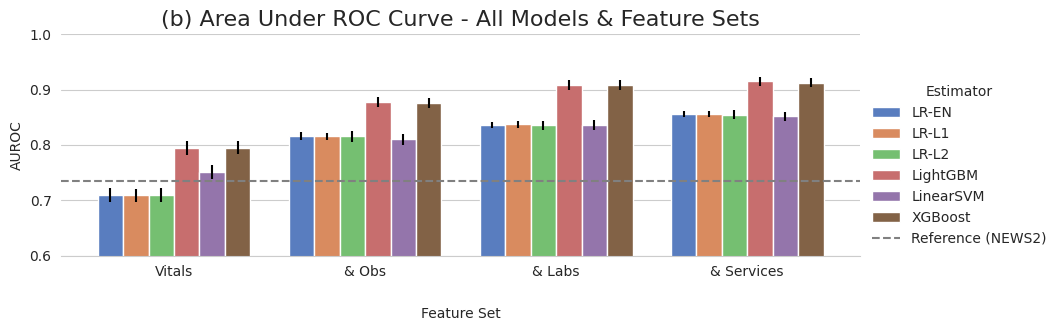

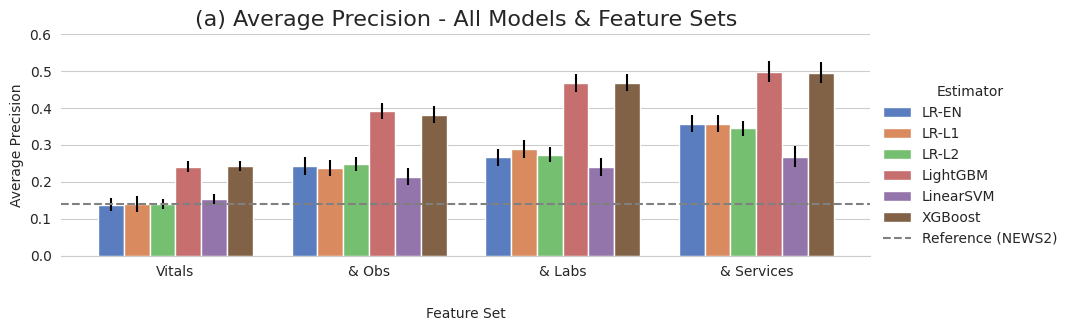

In [32]:
def select_feature_ablation_barplot(metrics_df, metric='AUROC', ylim=(0.0, 1.0), ylabel=None, title=None, save=None):
    sns.set_style('whitegrid')
    df = metrics_df[metrics_df.Estimator != 'NEWS2'].copy()
    err = (df[f'{metric}_Upper']-df[f'{metric}_Lower'])/2
    df['Features'] = pd.Categorical(
        df.Features.replace(PRETTY_PRINT_FEATURE_GROUPS), 
        ordered=True, categories=list(PRETTY_PRINT_FEATURE_GROUPS.values())[1:]
    )

    g = sns.catplot(
        data=df.sort_values(['Estimator','Features']), x='Features', y=metric, hue='Estimator',
        kind='bar', palette='muted', height=6, orient='v', legend=False
    )
    g.despine(left=True)
    g.fig.set_size_inches(9,3)
    g.ax.set_ylim(ylim)

    x_coords = [p.get_x() + 0.5*p.get_width() for p in g.ax.patches]
    y_coords = [p.get_height() for p in g.ax.patches]
    g.ax.errorbar(x=x_coords, y=y_coords, yerr=err, fmt="none", c= "k")

    news_performance = metrics_df.loc[metrics_df.Estimator == 'NEWS2', metric].values[0]

    g.refline(y = news_performance , color = 'gray', linestyle = '--', label = "Reference (NEWS2)") 
    g.add_legend(title='Estimator')
    
    g.set_xlabels("Feature Set", labelpad=20)
    g.ax.set_title(title, fontsize=16)
    
    if ylabel:
        g.set_ylabels(ylabel)

    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

select_feature_ablation_barplot(METRICS['Complete'], 'AUROC', (0.6, 1.0), ylabel='AUROC', title='(b) Area Under ROC Curve - All Models & Feature Sets', save=Notebook.IMAGE_DIR/'auc_bar.svg')
select_feature_ablation_barplot(METRICS['Complete'], 'AP', (0.0, 0.6), ylabel='Average Precision', title='(a) Average Precision - All Models & Feature Sets', save=Notebook.IMAGE_DIR/'ap_bar.svg')

## Calibration Curves

In [45]:
def estimator_y_preds_across_feature_groups(y_preds, estimator_target='LightGBM'):
    return {
        PRETTY_PRINT_FEATURE_GROUPS[feature_group]: y_pred_proba 
        for (estimator, feature_group), (y_pred_proba, *_) in y_preds.items()
        if estimator == estimator_target
    }

def feature_group_y_preds_across_estimators(y_preds, feature_group_target='with_services'):
    return {
        estimator: y_pred_proba
        for (estimator, feature_group), (y_pred_proba, *_) in y_preds.items()
        if feature_group == feature_group_target
    }

def all_y_preds_by_estimator(y_preds):
    return {
        estimator: y_pred_proba
        for (estimator, feature_group), (y_pred_proba, *_) in y_preds.items()
    }


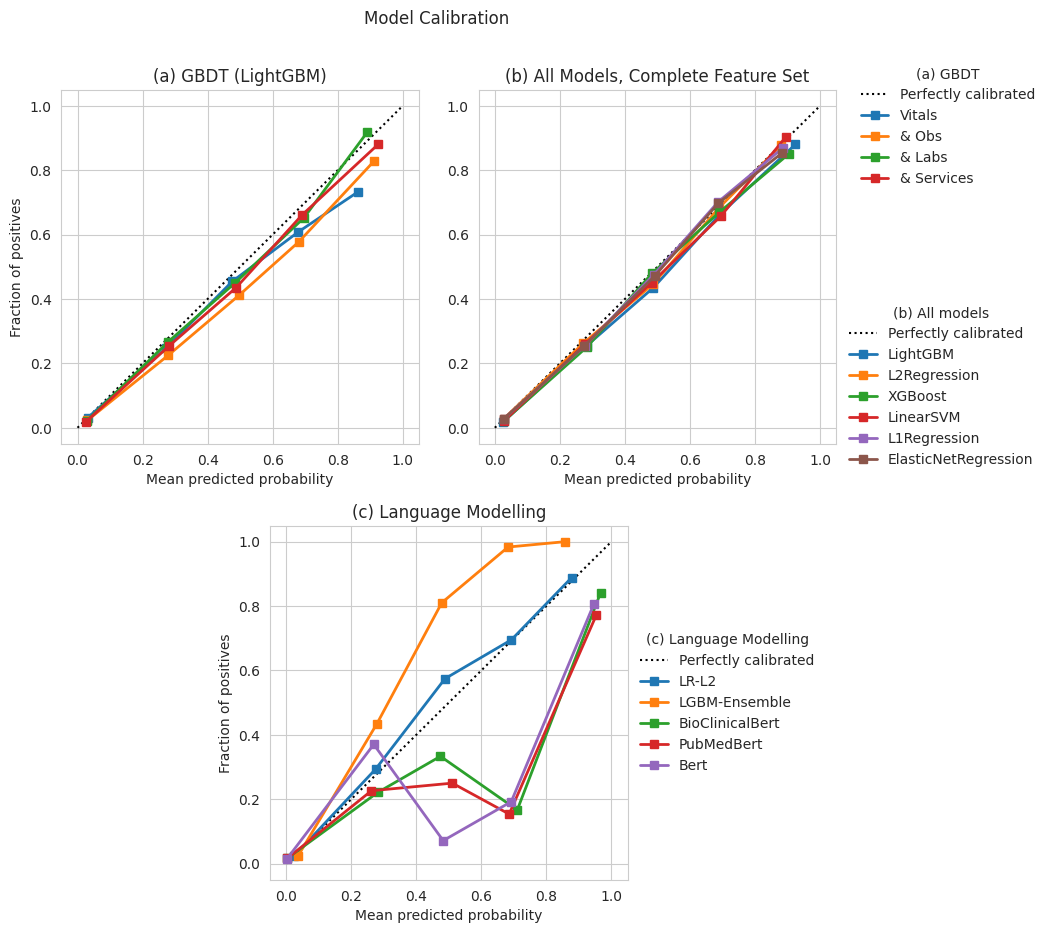

In [114]:
import matplotlib.gridspec
from transformer_experiment.utils.plots import plot_calibration_curves

def calib_curves(y_preds, y_preds_transf, save=None):
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(10,10))
    gs = matplotlib.gridspec.GridSpec(4, 4, hspace=0.6, wspace=0.4)
    ax1 = plt.subplot(gs[:2, :2])
    ax2 = plt.subplot(gs[:2, 2:])
    ax3 = plt.subplot(gs[2:4, 1:3])
    
    y_true = Y_TRUES['Complete']
    y_preds_l, y_preds_r, y_preds_d = (
        estimator_y_preds_across_feature_groups(y_preds, 'LightGBM'), 
        feature_group_y_preds_across_estimators(y_preds, 'with_services'),
        all_y_preds_by_estimator(y_preds_transf)
    )
    y_preds_r['LinearSVM'] = estimator_y_preds_across_feature_groups(y_preds, 'XGBoost')['& Labs']

    plot_calibration_curves(y_true, y_preds_l, ax=ax1, title='(a) GBDT (LightGBM)')
    plot_calibration_curves(y_true, y_preds_r, ax=ax2, title='(b) All Models, Complete Feature Set')
    plot_calibration_curves(y_true, y_preds_d, ax=ax3, title='(c) Language Modelling')

    sns.move_legend(ax1, "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='(a) GBDT')
    sns.move_legend(ax2, "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='(b) All models')
    sns.move_legend(ax3, "center left", bbox_to_anchor=(1, .5), frameon=False, title='(c) Language Modelling')
    ax2.set_ylabel(None)
   
   # fig.tight_layout(h_pad=0.5, w_pad=0.5)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Model Calibration')
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')
   
calib_curves(RESULTS, TRANSF_RESULTS_SELECT, save=Notebook.IMAGE_DIR/'calib_curves.svg')

## Alert Rate & PR

In [42]:
TEST_SET_N_DAYS = (
    SAL.loc[SAL_TEST_IDX].AdmissionDate.max() - SAL.loc[SAL_TEST_IDX].AdmissionDate.min()
).days
TEST_SET_N_DAYS

1010

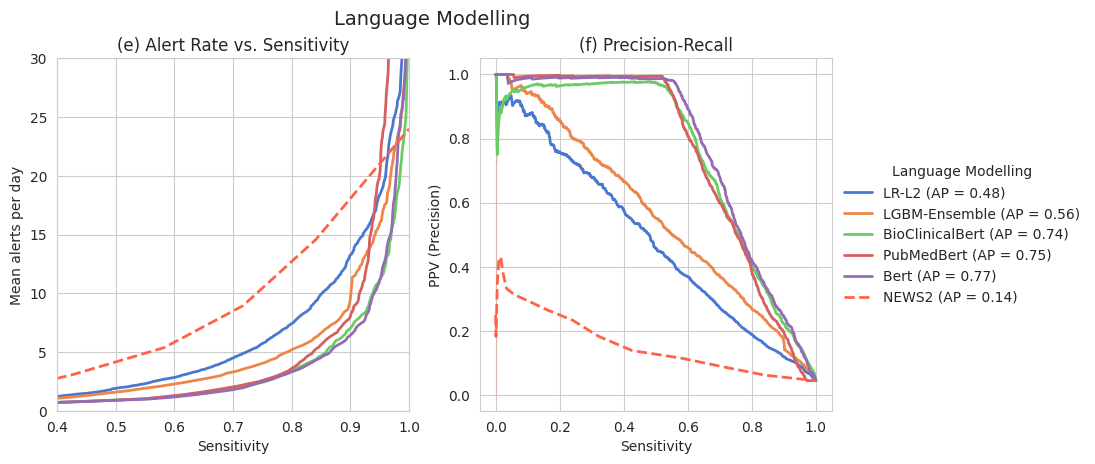

In [53]:
pr_and_alertrate_curves_transformers(
    TRANSF_RESULTS_SELECT, 
    title='Language Modelling', legend_label='Language Modelling',
    subtitle_lettering=['(e)', '(f)'],
    save=Notebook.IMAGE_DIR/'alert_pr_transf.svg'
)

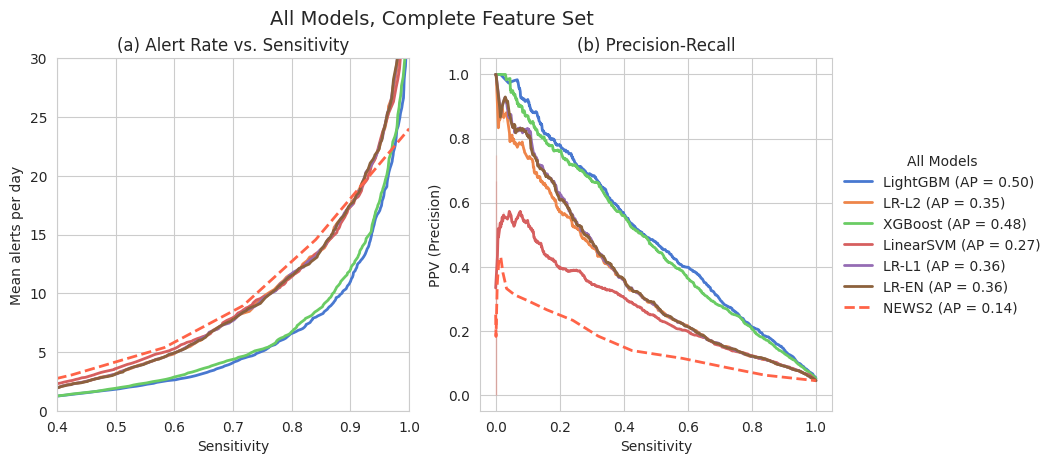

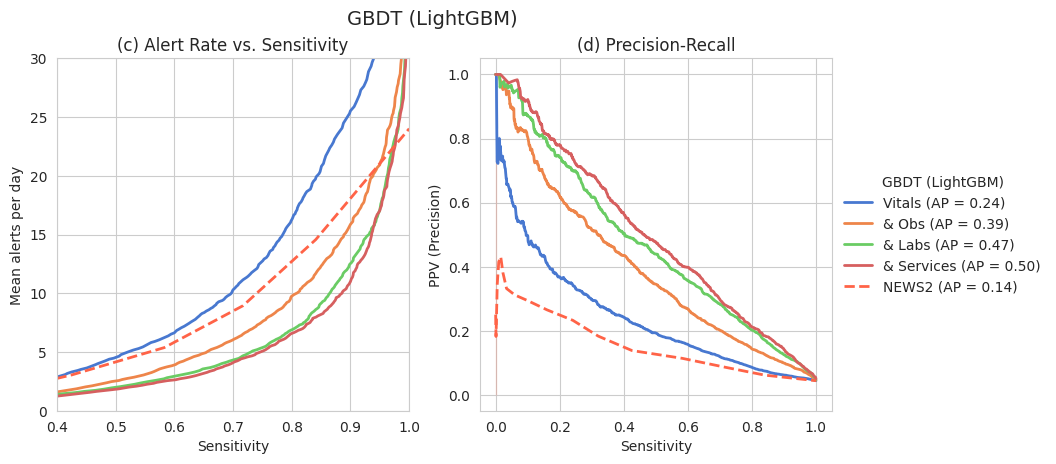

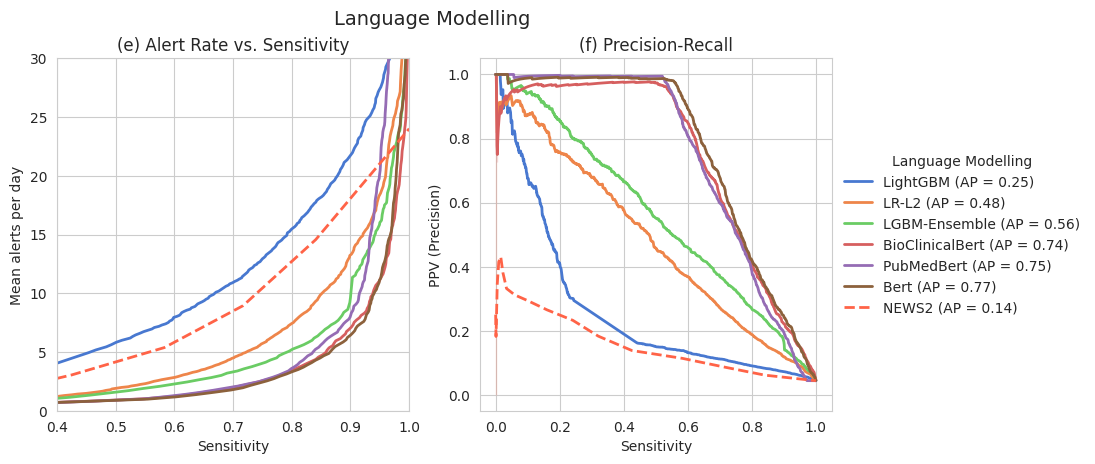

In [85]:
from transformer_experiment.utils.plots import plot_pr_curves, plot_alert_rate

def pr_and_alertrate_curves_estimator(y_preds, estimator, title, legend_label, subtitle_lettering, save=None):
    y_preds = estimator_y_preds_across_feature_groups(y_preds, estimator)   
    return pr_and_alertrate_curves(y_preds, title, legend_label, subtitle_lettering, save)

def pr_and_alertrate_curves_feature_group(y_preds, feature_group, title, legend_label, subtitle_lettering, save=None):
    y_preds = feature_group_y_preds_across_estimators(y_preds, feature_group)
    y_preds = {
        PRETTY_PRINT_ESTIMATORS[estimator]: y for estimator, y in y_preds.items()
    }
    return pr_and_alertrate_curves(y_preds, title, legend_label, subtitle_lettering, save)

def pr_and_alertrate_curves_transformers(y_preds_transf, title, legend_label, subtitle_lettering, save=None):
    y_preds = all_y_preds_by_estimator(y_preds_transf)
    return pr_and_alertrate_curves(y_preds, title, legend_label, subtitle_lettering, save)

def pr_and_alertrate_curves(y_preds, title, legend_label, subtitle_lettering, save=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)

    y_true = Y_TRUES['Complete']
    baseline_news = {'NEWS2': SAL.loc[y_true.index].NEWS_Score_Admission}
    
    with sns.color_palette('muted'):
        plot_alert_rate(
            y_true, y_preds | baseline_news, TEST_SET_N_DAYS,
            ax=ax[0], intercepts=False, baseline_key='NEWS2', 
            title=f'{subtitle_lettering[0]} Alert Rate vs. Sensitivity', xlim=(0.4, 1.0), ylim=(0, 30)
        )

        plot_pr_curves(
            y_true, y_preds | baseline_news, 
            smoothing=True, ax=ax[1], 
            palette=sns.color_palette('muted'), 
            baseline_key='NEWS2', 
            title=f'{subtitle_lettering[1]} Precision-Recall'
        )
        
    sns.move_legend(ax[1], "center left", bbox_to_anchor=(1, 0.5), frameon=False, title=legend_label)
    ax[0].legend([], [], frameon=False)
    
    fig.subplots_adjust(top=0.95)
    fig.suptitle(title, fontsize=14)

    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

pr_and_alertrate_curves_feature_group(
    RESULTS, 'with_services',
    title='All Models, Complete Feature Set', legend_label='All Models', 
    subtitle_lettering=['(a)', '(b)'],
    save=Notebook.IMAGE_DIR/'alert_pr_all.svg'
)
pr_and_alertrate_curves_estimator(
    RESULTS, 'LightGBM', 
    title='GBDT (LightGBM)', legend_label='GBDT (LightGBM)', 
    subtitle_lettering=['(c)', '(d)'],
    save=Notebook.IMAGE_DIR/'alert_pr_lightgbm.svg'
)
pr_and_alertrate_curves_transformers(
    TRANSF_RESULTS_SELECT, 
    title='Language Modelling', legend_label='Language Modelling',
    subtitle_lettering=['(e)', '(f)'],
    save=Notebook.IMAGE_DIR/'alert_pr_transf.svg'
)

### Intercepts

At sensitivity ~0.841: NEWS Alert rate: 14.574, Model Alert rate: 7.974 -> 45.285% less


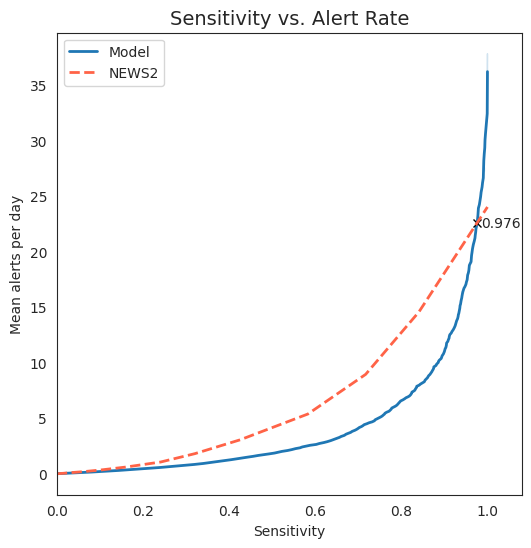

In [75]:
from transformer_experiment.utils.plots import plot_alert_rate, biggest_alert_rate_diff

def plot_alert_rate_with_intercepts(y_preds):
    y_true = Y_TRUES['Complete']
    baseline_news = {'NEWS2': SAL.loc[y_true.index].NEWS_Score_Admission}

    plot_alert_rate(
        y_true, {'Model': y_preds} | baseline_news, TEST_SET_N_DAYS,
        intercepts=True, baseline_key='NEWS2', 
    )

    sensitivity, news_rate, lgbm_rate = biggest_alert_rate_diff(
        y_true, baseline_news['NEWS2'], y_preds, TEST_SET_N_DAYS,
    )

    print(
        f"At sensitivity ~{sensitivity:.3f}: NEWS Alert rate: {news_rate:.3f}, Model Alert rate: {lgbm_rate:.3f} -> {100-(lgbm_rate*100/news_rate):.3f}% less"
    )

plot_alert_rate_with_intercepts(
    estimator_y_preds_across_feature_groups(RESULTS, 'LightGBM')['& Services']
)

At sensitivity ~0.841: NEWS Alert rate: 14.574, Model Alert rate: 4.388 -> 69.891% less


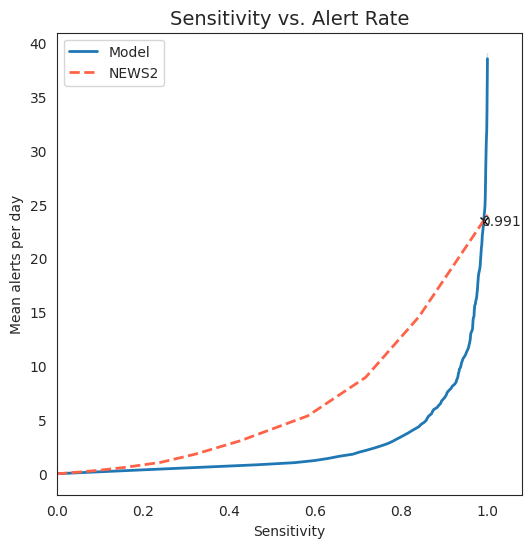

In [76]:
plot_alert_rate_with_intercepts(all_y_preds_by_estimator(TRANSF_RESULTS_SELECT)['BioClinicalBert'])

## SHAP

### Beeswarm Plot

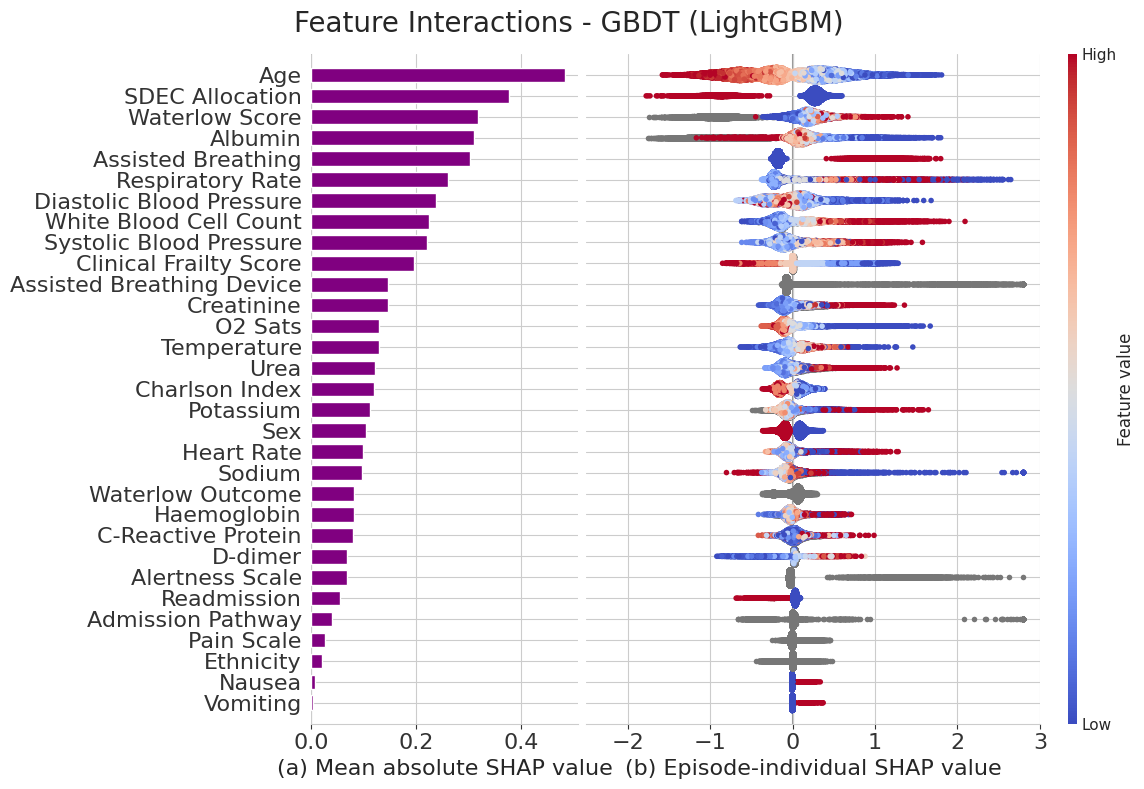

In [59]:
from transformer_experiment.utils.plots import plot_shap_features_joint

def lgbm_shap_beeswarm(y_preds, title='Feature Interactions - GBDT (LightGBM)', save=None):
    explanations = y_preds[('LightGBM', 'with_services')][-2]
    explanations.values[explanations.values >= 2.8] = 2.8
    plot_shap_features_joint(
        explanations, 
        max_display=250,
        figsize=(12, 8),
        wspace=-0.25,
        bar_aspect=0.04,
        topadjust=0.925,
        title=title,
        save=save
    )

lgbm_shap_beeswarm(RESULTS, save=Notebook.IMAGE_DIR/'shap_lgbm.png')

### Categorical Features

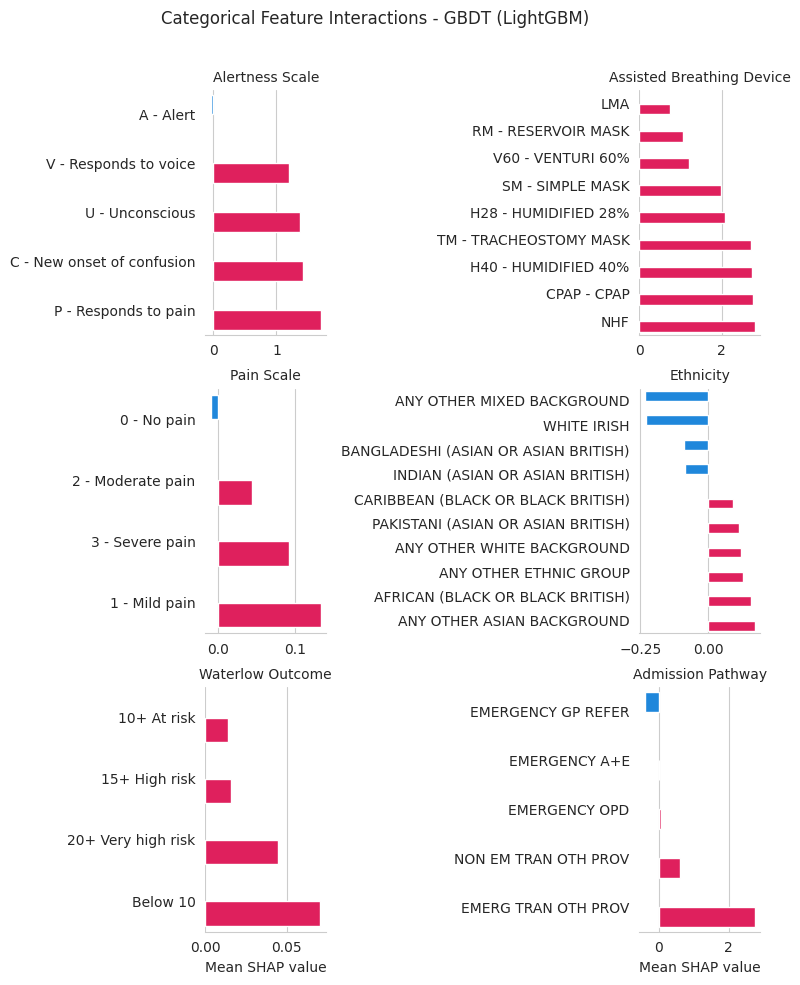

In [53]:
import shap
def categorical_shap_bars_lgbm(y_preds, save=None):
    explanations = y_preds[('LightGBM', 'with_services')][-2]
    
    r = []
    for column in SAL.categorical_columns(SalfordCombinations['with_services']):
        idx = explanations.feature_names.index(PRETTY_PRINT_FEATURE_NAMES[column])
        df = pd.DataFrame(
            zip(explanations[:, idx].values, explanations[:, idx].data), 
            columns=['Value', 'Data']).pivot(columns='Data').Value
        selected = df.apply(abs).mean().sort_values().tail(10).index
        r.append(df.mean().loc[selected].sort_values().rename('SHAP').to_frame().assign(Feature=PRETTY_PRINT_FEATURE_NAMES[column]))

    df = pd.concat(r).reset_index()

    #df['Data'] = df['Data'].replace(pretty_print_categoricals)
    #df['Feature'] = df['Feature'].replace({'A&E Diagnosis': 'ED Diagnosis'})
    df['Hue'] = (df.SHAP > 0).astype(int)
    sns.set_style('whitegrid')
    g = sns.catplot(
        data=df, x='SHAP', y='Data', col='Feature', hue='Hue', palette=[shap.plots.colors.blue_rgb, shap.plots.colors.red_rgb],
        kind='bar', orient='h', sharey=False, sharex=False, legend=False, col_wrap=2, 
        #col_order=['ED Diagnosis', 'Admission Specialty', 'Breathing Device', 'Admission Pathway', 'Presenting Complaint']
    )
    g.set_titles(template='{col_name}')
    g.fig.set_size_inches(8,10)
    g.fig.tight_layout()
    g.set_ylabels('')
    g.set_xlabels('Mean SHAP value')
    g.despine(left=True)
    g.fig.suptitle('Categorical Feature Interactions - GBDT (LightGBM)')
    g.fig.subplots_adjust(top=0.9)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

categorical_shap_bars_lgbm(RESULTS, Notebook.IMAGE_DIR/'shap_categorical.svg')

### Scatter Plots

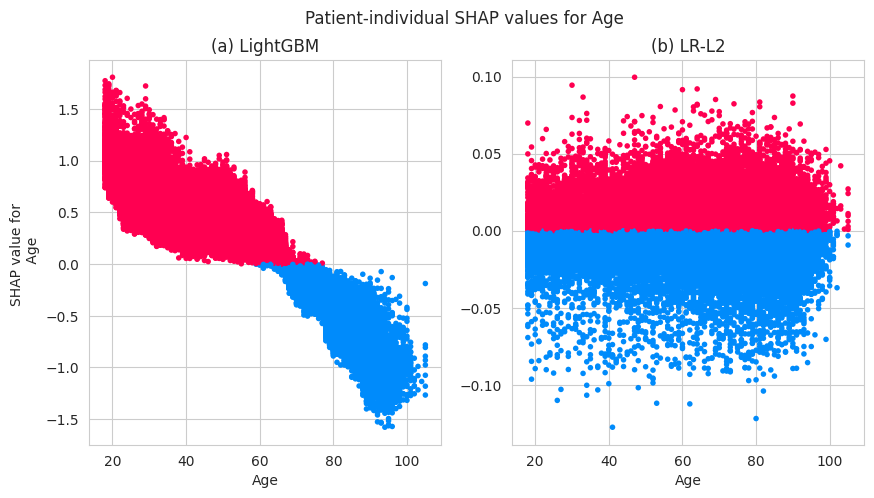

In [78]:
import shap
def comparison_scatter_plots(results, feature='Age', models=['LightGBM', 'L2Regression'], letters='ab', title=None, save=None):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    feature_name = PRETTY_PRINT_FEATURE_NAMES[feature]

    for i, model in enumerate(models):
        explanations = results[(model, 'with_services')][-2]
        
        explanations = explanations[:,explanations.feature_names.index(feature)]
        df = pd.concat([pd.Series(explanations.values, name='Value'), pd.Series(explanations.data, name=feature)], axis=1)
        if feature == 'Obs_Temperature_Admission':
            df = df[df.Obs_Temperature_Admission > 34]
            df = df[df.Obs_Temperature_Admission < 42]

        df['Colour'] = df.Value.apply(lambda x: x < 0)
        sns.scatterplot(data=df, x=feature, y='Value', hue='Colour', ax=ax[i], legend=False, palette=[shap.plots.colors.red_rgb, shap.plots.colors.blue_rgb], linewidth=0, s=16)
        ax[i].set_title(f'({letters[i]}) {PRETTY_PRINT_ESTIMATORS[model]}')
        points = ax[i].collections[0]
        points.set_rasterized(True)

    ax[0].set_ylabel(f'SHAP value for \n {feature_name}')
    ax[1].set_ylabel('')
    ax[0].set_xlabel(feature_name)
    ax[1].set_xlabel(feature_name)

    if not title:
        title = f'Patient-individual SHAP values for {feature_name}'
    fig.suptitle(title)

    if save:
        fig.savefig(save, bbox_inches='tight', format='svg')

comparison_scatter_plots(RESULTS, save=f'{Notebook.IMAGE_DIR}/shap_scatter_age.svg')

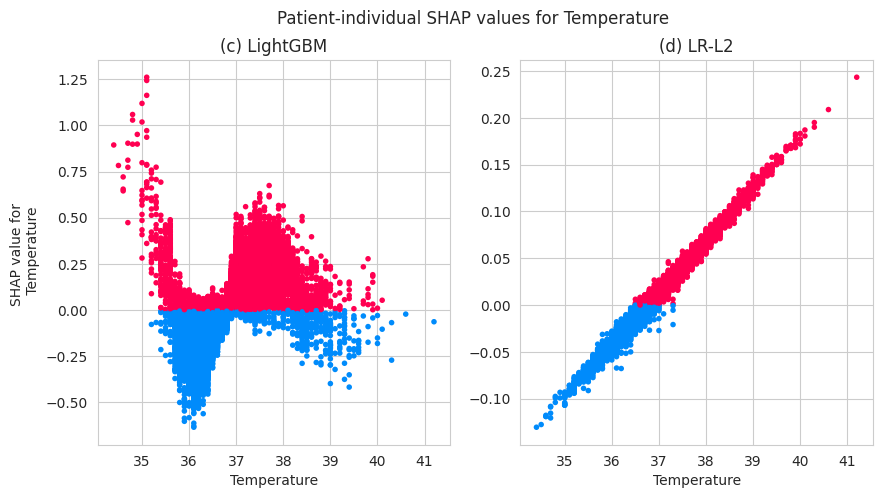

In [80]:
comparison_scatter_plots(RESULTS, feature='Obs_Temperature_Admission', save=f'{Notebook.IMAGE_DIR}/shap_scatter_temperature.svg', letters='cd')

## Regression Coefficinets

In [10]:
from transformer_experiment.utils.shallow_classifiers import get_calibrated_regression_coefficients

def get_onehot_columns():
    X, y = SalfordAdapter(SAL.loc[SAL_TRAIN_IDX]).xy(x=SalfordCombinations['with_services'], onehot_encoding=True)
    r = X.get_onehot_categorical_columns()
    for column in r.keys():
        r[column].append(f'{column}__NAN')
    return r

def plot_calibrated_regression_coefficients(
    model, columns, topn=60, figsize=(8, 12), pipeline_key=None, save=None,
):
    df = get_calibrated_regression_coefficients(model, columns, pipeline_key)
    regression_coefficient_sorted_barplot(df, topn=topn, save=save)

def get_logistic_regression_coefficients(model, estimator_name, onehot_cols):
    coef = get_calibrated_regression_coefficients(
        model, estimator_name
    ).set_index('Feature').Coefficient

    coef_num = coef[~coef.index.isin([__ for _ in onehot_cols.values() for __ in _])].sort_values()
    coef_cat = pd.DataFrame([dict(
        Feature=PRETTY_PRINT_FEATURE_NAMES[key],
        Value=_,
        Coef=coef.loc[_]    
    ) for key, val in onehot_cols.items() for _ in val if _ in coef.index])
    coef_cat.Value = coef_cat.Value.str.split('__').str[1]

    return coef_num, coef_cat

In [11]:
def categorical_coefficient_table(results, onehot_cols, estimators=['L1Regression', 'L2Regression', 'ElasticNetRegression'], feature_group='with_services'):
    r = pd.concat((
        get_logistic_regression_coefficients(
            results[(estimator, feature_group)][-1], estimator, onehot_cols
        )[1].assign(Estimator=PRETTY_PRINT_ESTIMATORS[estimator]).replace('NAN', 'Unknown')
    ) for estimator in estimators)

    top = r.copy()
    top.Coef = top.Coef.apply(abs)
    top = top.groupby(['Feature', 'Value']).mean().groupby('Feature').Coef.nlargest(5).droplevel(0).index
    return r.pivot(index=['Feature', 'Value'], columns='Estimator', values='Coef').loc[top].round(4)

categorical_logistic_coefficients_table = categorical_coefficient_table(RESULTS, get_onehot_columns())
#categorical_logistic_coefficients_table

In [16]:
#print(categorical_logistic_coefficients_table.to_latex(bold_rows=True, multirow=True, column_format='llrrr',  formatters=[lambda x: f'${x}$' for _ in range(categorical_logistic_coefficients_table.shape[1])], escape=False))

In [77]:
def numerical_coefficient_table(results, onehot_cols, estimators=['L1Regression', 'L2Regression', 'ElasticNetRegression'], feature_group='with_services'):
    r = pd.concat((
        (
            get_logistic_regression_coefficients(results[(estimator, feature_group)][-1], estimator, onehot_cols)[0].rename(estimator)
        ) for estimator in estimators), axis=1
    ).round(4)

    r.index = map(PRETTY_PRINT_FEATURE_NAMES.get, r.index)
    r.columns = map(PRETTY_PRINT_ESTIMATORS.get, r.columns)
    return r

numerical_logistic_coefficients_table = numerical_coefficient_table(RESULTS, get_onehot_columns())
numerical_logistic_coefficients_table

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


,LR-L1,LR-L2,LR-EN
SDEC Allocation,-2.0002,-1.8570,-1.9932
Diastolic Blood Pressure,-0.7440,-0.7254,-0.7421
Readmission,-0.5305,-0.5121,-0.5289
Assisted Breathing,-0.3285,-0.3239,-0.3278
White Blood Cell Count,-0.2945,-0.2879,-0.2941
Potassium,-0.2426,-0.2445,-0.2425
O2 Sats,-0.2371,-0.2219,-0.2360
Sex,-0.2262,-0.2386,-0.2271
Waterlow Score,-0.1721,-0.1667,-0.1717
Nausea,-0.0277,-0.0271,-0.0269


In [80]:
#print(numerical_logistic_coefficients_table.to_latex(bold_rows=True, column_format='lrrr',  formatters=[lambda x: f'${x}$' for _ in range(numerical_logistic_coefficients_table.shape[1])], escape=False))

## Bias

### Entropy Curves

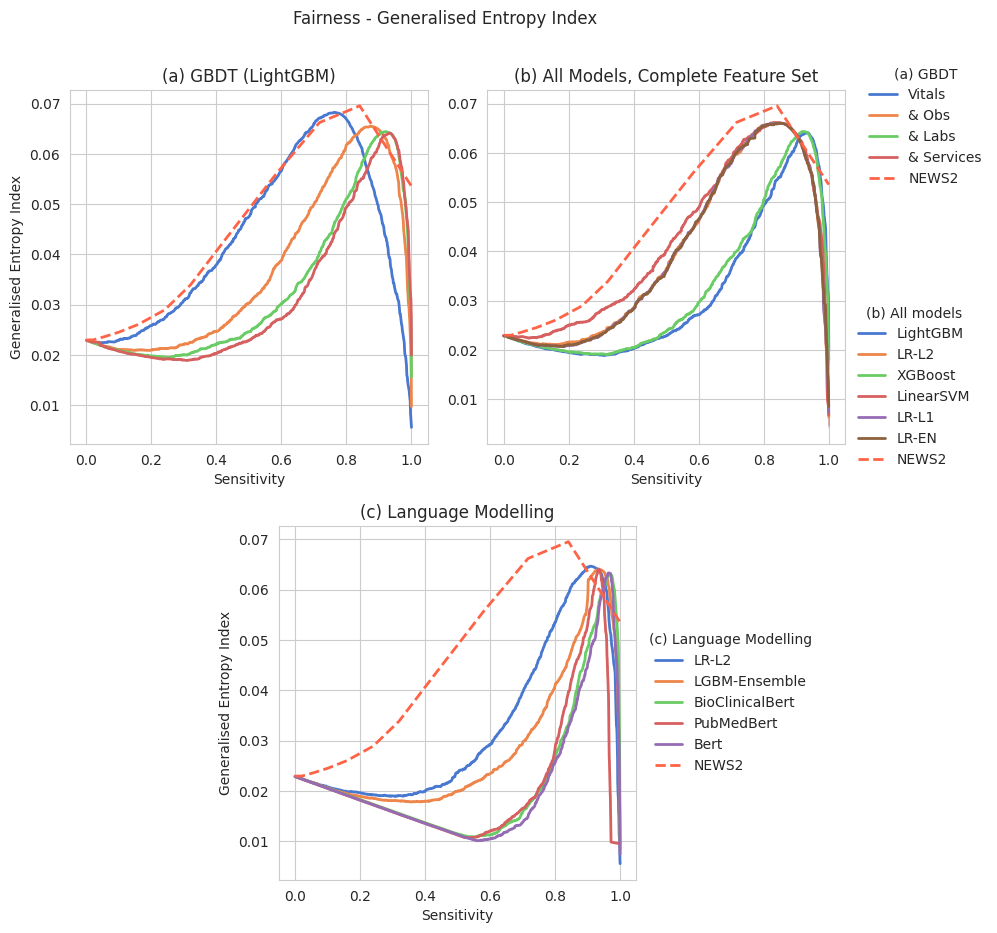

In [144]:
import matplotlib.gridspec
from transformer_experiment.utils.plots import plot_entropy_curves
from aif360.sklearn.metrics import generalized_entropy_error, between_group_generalized_entropy_error

def entropy_comparison(y_preds, y_preds_transf, prot_attr=None, save=None, function=generalized_entropy_error, title='Fairness - Generalised Entropy Index'):
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(10,10))
    gs = matplotlib.gridspec.GridSpec(4, 4, hspace=0.6, wspace=0.4)
    ax1 = plt.subplot(gs[:2, :2])
    ax2 = plt.subplot(gs[:2, 2:])
    ax3 = plt.subplot(gs[2:4, 1:3])

    y_true = Y_TRUES['Complete']
    baseline_news = {'NEWS2': SAL.loc[y_true.index].NEWS_Score_Admission}

    y_preds_l, y_preds_r, y_preds_d = (
        estimator_y_preds_across_feature_groups(y_preds, 'LightGBM') | baseline_news, 
        feature_group_y_preds_across_estimators(y_preds, 'with_services') | baseline_news,
        all_y_preds_by_estimator(y_preds_transf) | baseline_news
    )

    y_preds_r = {PRETTY_PRINT_ESTIMATORS[key]:value for key, value in y_preds_r.items()}

    plot_entropy_curves(
        y_true, y_preds_l, 
        function=function, prot_attr=prot_attr,
        ax=ax1, title='(a) GBDT (LightGBM)', 
        baseline_key='NEWS2', palette=sns.color_palette('muted')
    )
    plot_entropy_curves(
        y_true, y_preds_r, 
        function=function, prot_attr=prot_attr,
        ax=ax2, title='(b) All Models, Complete Feature Set', 
        baseline_key='NEWS2', palette=sns.color_palette('muted')
    )
    plot_entropy_curves(
        y_true, y_preds_d, 
        function=function, prot_attr=prot_attr,
        ax=ax3, title='(c) Language Modelling', 
        baseline_key='NEWS2', palette=sns.color_palette('muted'), ci=None
    )

    sns.move_legend(ax1, "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='(a) GBDT')
    sns.move_legend(ax2, "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='(b) All models')
    sns.move_legend(ax3, "center left", bbox_to_anchor=(1, .5), frameon=False, title='(c) Language Modelling')

    ax2.set_ylabel(None)
    fig.subplots_adjust(top=0.9)
    fig.suptitle(title)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

entropy_comparison(RESULTS, TRANSF_RESULTS_SELECT, save=Notebook.IMAGE_DIR/'entropy.svg') 


KeyboardInterrupt: 

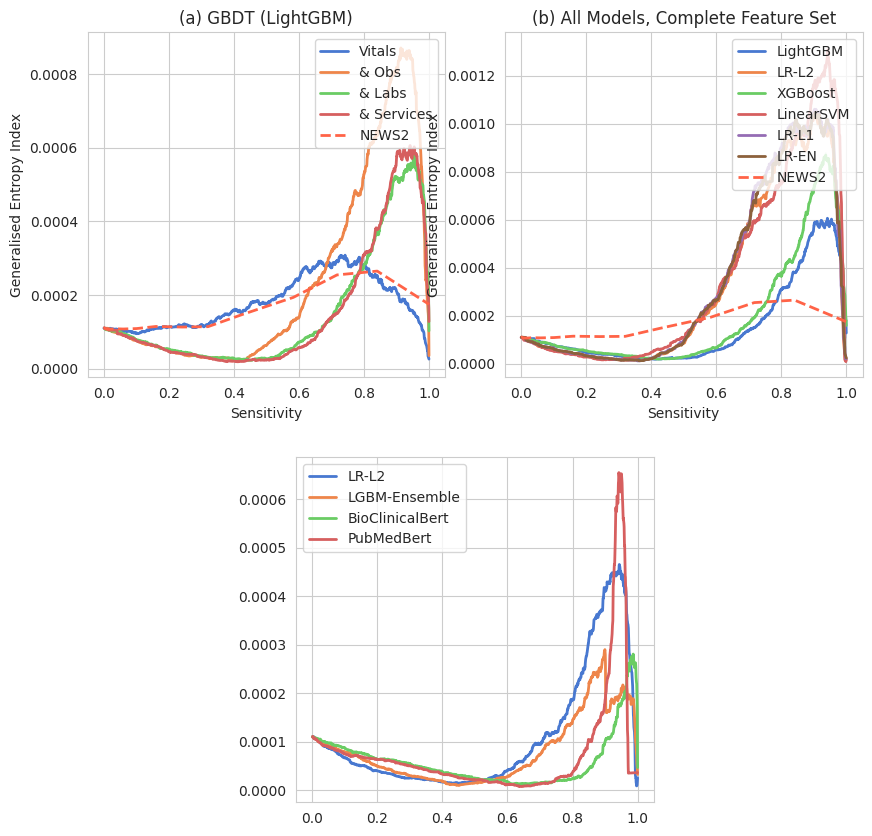

In [145]:
SAL.loc[SAL_TEST_IDX, 'Ethnicity'] = SAL.loc[SAL_TEST_IDX, 'Ethnicity'].fillna("WHITE BRITISH")
entropy_comparison(
    RESULTS, TRANSF_RESULTS_SELECT, 
    function=between_group_generalized_entropy_error, 
    prot_attr=(
        SAL.loc[SAL_TEST_IDX].CriticalEvent.set_axis(
            SAL.loc[SAL_TEST_IDX, ['Female', 'Ethnicity']]
        ).index), 
    save=Notebook.IMAGE_DIR/'entropy_between.svg', 
    title='Between-Group Fairness - Generalised Entropy Index'
)

### Bias Amplification

In [135]:
from transformer_experiment.utils.shallow_classifiers import bootstrap_bias_amplification

def calculate_bias_amplifications(y_preds):
    X = SAL.loc[SAL_TEST_IDX]
    y_true = Y_TRUES['Complete']

    prot_attrs = dict(
        Sex=X.Female,
        Ethnicity=X.Ethnicity.fillna("WHITE BRITISH"),
        Both=y_true.set_axis(X[['Female', 'Ethnicity']].fillna("WHITE BRITISH")).index,
    )
  

    get_dict = lambda low, mid, high: dict(
        Bias_Amp = mid,
        Bias_Amp_Lower = low,
        Bias_Amp_Upper = high
    )

    df = pd.DataFrame(dict(
        Estimator=estimator,
        Features=features,
        Protected=attr_key
    ) | get_dict(*bootstrap_bias_amplification(
        y_true, y_pred_proba, prot_attr, n_resamples=9
    )) for (estimator, features), (y_pred_proba, *_) in y_preds.items()
        for attr_key, prot_attr in prot_attrs.items()
    )

    df['Bias'] = df.Bias_Amp.map('{:.3f}'.format) + ' (' + df.Bias_Amp_Lower.map('{:.3f}'.format) + ' - ' + df.Bias_Amp_Upper.map('{:.3f}'.format) + ')'
    
    print(f'Median: {df[df.Protected=="Both"].Bias_Amp.median()}')

    return df.pivot(index=['Features', 'Estimator'], columns=['Protected'], values='Bias')[['Sex', 'Ethnicity', 'Both']]

result_bias_amp = calculate_bias_amplifications(RESULTS)
result_bias_amp

Median: -1.273367681464634


Protected                                                 Sex  \
Features       Estimator                                        
news           ElasticNetRegression  -0.427 (-0.458 - -0.333)   
               L1Regression          -0.427 (-0.459 - -0.333)   
               L2Regression          -0.428 (-0.460 - -0.335)   
               LightGBM              -0.449 (-0.482 - -0.358)   
               LinearSVM             -0.444 (-0.477 - -0.357)   
               XGBoost               -0.450 (-0.485 - -0.364)   
with_labs      ElasticNetRegression   -0.042 (-0.095 - 0.024)   
               L1Regression           -0.051 (-0.103 - 0.013)   
               L2Regression           -0.055 (-0.106 - 0.012)   
               LightGBM              -0.076 (-0.125 - -0.029)   
               LinearSVM              -0.064 (-0.114 - 0.012)   
               XGBoost               -0.050 (-0.103 - -0.001)   
with_phenotype ElasticNetRegression   -0.055 (-0.100 - 0.004)   
               L1Regression          -0.082 (-0.128 - -0.020)   
               L2Regression          -0.069 (-0.111 - -0.011)   
               LightGBM              -0.069 (-0.116 - -0.009)   
               LinearSVM             -0.148 (-0.192 - -0.083)   
               XGBoost               -0.084 (-0.138 - -0.028)   
with_services  ElasticNetRegression   -0.060 (-0.107 - 0.001)   
               L1Regression          -0.063 (-0.110 - -0.002)   
               L2Regression          -0.063 (-0.112 - -0.000)   
               LightGBM              -0.062 (-0.104 - -0.013)   
               LinearSVM              -0.066 (-0.113 - 0.007)   
               XGBoost               -0.050 (-0.099 - -0.007)   

Protected                                           Ethnicity  \
Features       Estimator                                        
news           ElasticNetRegression  -1.389 (-1.803 - -1.001)   
               L1Regression          -1.399 (-1.811 - -0.998)   
               L2Regression          -1.413 (-1.804 - -0.995)   
               LightGBM              -1.413 (-1.898 - -0.925)   
               LinearSVM             -1.404 (-1.877 - -0.971)   
               XGBoost               -1.402 (-1.845 - -0.961)   
with_labs      ElasticNetRegression  -0.769 (-1.268 - -0.342)   
               L1Regression          -0.779 (-1.295 - -0.363)   
               L2Regression          -0.726 (-1.233 - -0.294)   
               LightGBM              -0.890 (-1.248 - -0.506)   
               LinearSVM             -0.820 (-1.341 - -0.431)   
               XGBoost               -0.835 (-1.282 - -0.420)   
with_phenotype ElasticNetRegression  -0.823 (-1.309 - -0.431)   
               L1Regression          -1.058 (-1.556 - -0.636)   
               L2Regression          -0.776 (-1.214 - -0.378)   
               LightGBM              -0.757 (-1.191 - -0.255)   
               LinearSVM             -0.995 (-1.456 - -0.618)   
               XGBoost               -0.616 (-1.066 - -0.168)   
with_services  ElasticNetRegression  -0.531 (-1.143 - -0.107)   
               L1Regression          -0.523 (-1.147 - -0.098)   
               L2Regression          -0.596 (-1.203 - -0.169)   
               LightGBM              -0.818 (-1.173 - -0.366)   
               LinearSVM             -0.823 (-1.345 - -0.403)   
               XGBoost               -0.651 (-1.094 - -0.200)   

Protected                                                Both  
Features       Estimator                                       
news           ElasticNetRegression  -2.028 (-2.212 - -1.554)  
               L1Regression          -2.036 (-2.212 - -1.559)  
               L2Regression          -2.026 (-2.207 - -1.550)  
               LightGBM              -1.914 (-2.094 - -1.419)  
               LinearSVM             -1.960 (-2.126 - -1.505)  
               XGBoost               -1.892 (-2.034 - -1.412)  
with_labs      ElasticNetRegression  -1.128 (-1.344 - -0.792)  
               L1Regression          -1.16

In [68]:
#print(result_bias_amp.to_latex(bold_rows=True, multirow=True, multicolumn=True, longtable=False, column_format='ll|ccc'))

In [137]:
result_bias_amp_transf_shallow = calculate_bias_amplifications(TRANSF_RESULTS_SHALLOW)
result_bias_amp_transf_shallow

Median: -1.6047794513469829


Protected                                            Sex  \
Features        Estimator                                  
Bert            LGBM-Ensemble   -0.213 (-0.248 - -0.152)   
                LR-L2           -0.087 (-0.122 - -0.020)   
                LR-L2-Ensemble  -0.207 (-0.246 - -0.146)   
                LightGBM        -0.378 (-0.406 - -0.293)   
BioClinicalBert LGBM-Ensemble   -0.197 (-0.233 - -0.136)   
                LR-L2           -0.111 (-0.161 - -0.040)   
                LR-L2-Ensemble  -0.204 (-0.247 - -0.142)   
                LightGBM        -0.353 (-0.387 - -0.268)   
PubMedBert      LGBM-Ensemble   -0.198 (-0.240 - -0.133)   
                LR-L2           -0.107 (-0.148 - -0.026)   
                LR-L2-Ensemble  -0.205 (-0.245 - -0.137)   
                LightGBM        -0.350 (-0.393 - -0.259)   

Protected                                      Ethnicity  \
Features        Estimator                                  
Bert            LGBM-Ensemble   -1.109 (-1.537 - -0.763)   
                LR-L2           -0.504 (-1.066 - -0.027)   
                LR-L2-Ensemble  -0.946 (-1.513 - -0.604)   
                LightGBM        -1.153 (-1.619 - -0.856)   
BioClinicalBert LGBM-Ensemble   -1.116 (-1.586 - -0.760)   
                LR-L2            -0.523 (-1.046 - 0.018)   
                LR-L2-Ensemble  -0.955 (-1.498 - -0.584)   
                LightGBM        -1.162 (-1.625 - -0.781)   
PubMedBert      LGBM-Ensemble   -1.100 (-1.487 - -0.747)   
                LR-L2           -0.488 (-1.103 - -0.156)   
                LR-L2-Ensemble  -0.941 (-1.524 - -0.693)   
                LightGBM        -1.079 (-1.624 - -0.797)   

Protected                                           Both  
Features        Estimator                                 
Bert            LGBM-Ensemble   -1.659 (-2.057 - -1.306)  
                LR-L2           -0.933 (-1.130 - -0.642)  
                LR-L2-Ensemble  -1.461 (-1.786 - -1.145)  
                LightGBM        -1.780 (-2.264 - -1.288)  
BioClinicalBert LGBM-Ensemble   -1.688 (-2.005 - -1.315)  
                LR-L2           -1.014 (-1.180 - -0.659)  
                LR-L2-Ensemble  -1.539 (-1.872 - -1.151)  
                LightGBM        -1.775 (-2.206 - -1.294)  
PubMedBert      LGBM-Ensemble   -1.621 (-1.954 - -1.298)  
                LR-L2           -0.984 (-1.107 - -0.677)  
                LR-L2-Ensemble  -1.589 (-1.836 - -1.209)  
                LightGBM        -1.633 (-2.052 - -1.263)

In [141]:
result_bias_amp_transf_deep = calculate_bias_amplifications(TRANSF_RESULTS_DEEP).loc[['Notes', 'Diagnoses', 'Tabular', 'All']]
result_bias_amp_transf_deep

Protected                                       Sex                 Ethnicity  \
Features  Estimator                                                             
Notes     Bert             -0.270 (-0.312 - -0.165)  -0.489 (-1.318 - -0.266)   
          BioClinicalBert  -0.335 (-0.381 - -0.241)  -1.128 (-1.535 - -0.736)   
          PubMedBert       -0.238 (-0.277 - -0.116)  -0.605 (-1.202 - -0.172)   
Diagnoses Bert              -0.035 (-0.059 - 0.065)  -0.513 (-1.318 - -0.115)   
          BioClinicalBert  -0.122 (-0.196 - -0.008)  -0.774 (-1.182 - -0.366)   
          PubMedBert       -0.441 (-0.485 - -0.365)  -1.233 (-1.775 - -0.848)   
Tabular   Bert                0.027 (0.021 - 0.095)   -0.089 (-0.321 - 0.260)   
          BioClinicalBert     0.026 (0.004 - 0.106)  -0.357 (-0.859 - -0.064)   
          PubMedBert        -0.054 (-0.070 - 0.014)   -0.226 (-0.774 - 0.125)   
All       Bert              -0.011 (-0.044 - 0.073)   -0.144 (-0.429 - 0.273)   
          BioClinicalBert   -0.012 (-0.052 - 0.061)    0.004 (-0.321 - 0.526)   
          PubMedBert        -0.000 (-0.011 - 0.076)   -0.175 (-0.750 - 0.187)   

Protected                                      Both  
Features  Estimator                                  
Notes     Bert             -0.942 (-1.408 - -0.518)  
          BioClinicalBert  -1.407 (-1.806 - -1.174)  
          PubMedBert       -0.951 (-1.423 - -0.569)  
Diagnoses Bert             -0.476 (-0.804 - -0.226)  
          BioClinicalBert  -1.106 (-1.515 - -0.796)  
          PubMedBert       -1.921 (-2.172 - -1.465)  
Tabular   Bert              -0.162 (-0.409 - 0.132)  
          BioClinicalBert  -0.495 (-0.679 - -0.183)  
          PubMedBert       -0.576 (-0.870 - -0.353)  
All       Bert               0.369 (-0.151 - 0.592)  
          BioClinicalBert    0.357 (-0.083 - 0.591)  
          PubMedBert       -0.276 (-0.394 - -0.038)

In [143]:

print(pd.concat((result_bias_amp_transf_deep, result_bias_amp_transf_shallow)).to_latex(bold_rows=True, multirow=True, multicolumn=True, longtable=False, column_format='ll|ccc'))

\begin{tabular}{ll|ccc}
\toprule
           & \textbf{Protected} &                       Sex &                 Ethnicity &                      Both \\
\textbf{Features} & \textbf{Estimator} &                           &                           &                           \\
\midrule
\multirow{3}{*}{\textbf{Notes}} & \textbf{Bert} &  -0.270 (-0.312 - -0.165) &  -0.489 (-1.318 - -0.266) &  -0.942 (-1.408 - -0.518) \\
           & \textbf{BioClinicalBert} &  -0.335 (-0.381 - -0.241) &  -1.128 (-1.535 - -0.736) &  -1.407 (-1.806 - -1.174) \\
           & \textbf{PubMedBert} &  -0.238 (-0.277 - -0.116) &  -0.605 (-1.202 - -0.172) &  -0.951 (-1.423 - -0.569) \\
\cline{1-5}
\multirow{3}{*}{\textbf{Diagnoses}} & \textbf{Bert} &   -0.035 (-0.059 - 0.065) &  -0.513 (-1.318 - -0.115) &  -0.476 (-0.804 - -0.226) \\
           & \textbf{BioClinicalBert} &  -0.122 (-0.196 - -0.008) &  -0.774 (-1.182 - -0.366) &  -1.106 (-1.515 - -0.796) \\
           & \textbf{PubMedBert} &  -0.441 (-0.485 - -0.3

## Scored vs. Unscored

In [19]:
from salford_datasets.salford import _generate_salford_feature_combinations

def train_scored_models():
    scored_feature_groups = _generate_salford_feature_combinations(scored=True)[1]
    study_grid = list(itertools.product(['LightGBM', 'L2Regression'], list(scored_feature_groups.keys())))
    results = {}

    for estimator_name, feature_group_name in (pbar := tqdm(study_grid)):
        pbar.set_description(f'Training {estimator_name} on {feature_group_name}')
        results[(estimator_name, feature_group_name)] = run_pretuned(
            SAL, estimator_name, feature_group_name, explain_models=[], 
            feature_columns=scored_feature_groups[feature_group_name]
        )

    return results

if Notebook.RE_DERIVE:
    RESULTS_SCORED = train_scored_models()
    with open(Notebook.CACHE_DIR/'shallow_results_2_scored.bin', 'wb') as file:
        pickle.dump(RESULTS_SCORED, file)
else:
    with open(Notebook.CACHE_DIR/'shallow_results_2_scored.bin', 'rb') as file:
        RESULTS_SCORED = pickle.load(file)

METRICS_SCORED = get_full_metrics_tables(RESULTS_SCORED)

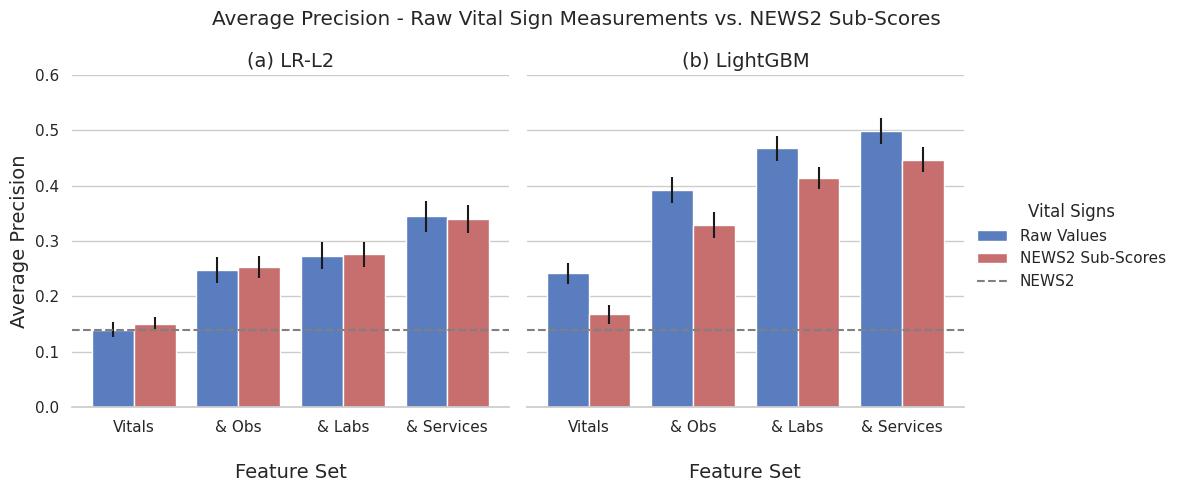

In [23]:
def subscores_barplot(metrics, metrics_scored, score='AP', ylim=(0.0, 0.6), save=None, estimators=['LR-L2', 'LightGBM']):
    metrics_scored = metrics_scored.copy()
    # metrics_scored.loc[
    #     (metrics_scored.Estimator == 'LightGBM')&
    #     (~metrics_scored.Features.isin(['Vitals', '& Services'])), score] -= 0.01
    
    df = pd.concat([
        metrics[metrics.Estimator.isin(estimators)].copy().assign(Dataset='Raw Values'),
        metrics_scored[metrics_scored.Estimator.isin(estimators)].copy().assign(Dataset='NEWS2 Sub-Scores')
    ], axis=0).rename(columns={'Dataset': 'Vital Signs'})
    

    err = (df[f'{score}_Upper']-df[f'{score}_Lower'])/2
    df = df.rename(columns=dict(
        features='Features',
        estimator='Model',
    ))

    df['Estimator'] = df.Estimator.replace({
        'LR-L2': '(a) LR-L2',
        'LightGBM': '(b) LightGBM'
    })

    sns.set_style('whitegrid')

    g = sns.catplot(
        data=df, x='Features', y=score, hue='Vital Signs', col='Estimator',
        kind='bar', palette=[sns.color_palette('muted')[0], sns.color_palette('muted')[3]], height=6, orient='v', legend=False, 
        col_order=['(a) LR-L2', '(b) LightGBM']
    )
    g.despine(left=True)
    g.fig.set_size_inches(10,5)

    subp = [(i, model, ax) for i, (model, ax) in enumerate(g.axes_dict.items())]
    for i, estimator, ax in subp:
        ax.set_ylim(ylim)
        x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
        y_coords = [p.get_height() for p in ax.patches]
        ax.errorbar(x=x_coords, y=y_coords, yerr=err[(df.Estimator==estimator)], fmt="none", c= "k")

    g.set_xlabels("Feature Set", labelpad=20, fontsize=14)
    g.set_ylabels('Average Precision', fontsize=14)
    g.refline(y = metrics.loc[metrics.Estimator=='NEWS2', score].values[0], color = 'gray', linestyle = '--', label = "NEWS2") 
    g.add_legend(title='Vital Signs')
    
    g.set_titles(template='{col_name}', size=14)
    g.fig.suptitle('Average Precision - Raw Vital Sign Measurements vs. NEWS2 Sub-Scores')
    g.fig.subplots_adjust(top=0.85)

    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

subscores_barplot(METRICS['Complete'], METRICS_SCORED['Complete'], save=Notebook.IMAGE_DIR/'raw_vs_scored_ap.svg')


## Time Thresholds

In [7]:
from sklearn.metrics import roc_auc_score

def run_time_thresholds_experiment(sal):
    time_study_grid = list(itertools.product(['LightGBM', 'L2Regression'], list(PRETTY_PRINT_FEATURE_GROUPS.keys())[1:], range(1, 31)))

    get_y_true = lambda threshold: SalfordAdapter(sal.loc[SAL_TEST_IDX]).derive_critical_event(within=threshold, return_series=True)
    y_trues_memoisation = {}

    for estimator_name, feature_group_name, outcome_threshold in (pbar := tqdm(time_study_grid)):
        pbar.set_description(f'Training {estimator_name} on {feature_group_name}-{outcome_threshold}')
        if outcome_threshold not in y_trues_memoisation:
            y_trues_memoisation[outcome_threshold] = get_y_true(outcome_threshold)        
        y_true = y_trues_memoisation[outcome_threshold]

        y_pred_proba = run_pretuned(sal, estimator_name, feature_group_name, explain_models=[], outcome_within=outcome_threshold)[0]
        RESULTS_TIME[(estimator_name, feature_group_name, outcome_threshold)] = roc_auc_score(y_true, y_pred_proba)

    return RESULTS_TIME

if Notebook.RE_DERIVE or True:
    RESULTS_TIME = {}
    run_time_thresholds_experiment(SAL)
    with open(Notebook.CACHE_DIR/'shallow_results_2_time.bin', 'wb') as file:
        pickle.dump(RESULTS_TIME, file)
else:
    with open(Notebook.CACHE_DIR/'shallow_results_2_time.bin', 'rb') as file:
        RESULTS_TIME = pickle.load(file)

Training L2Regression on with_services-30: 100%|██████████| 240/240 [18:10<00:00,  4.54s/it] 


The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.


Vitals: 0.7996996710292796 -> 0.7709121234518893


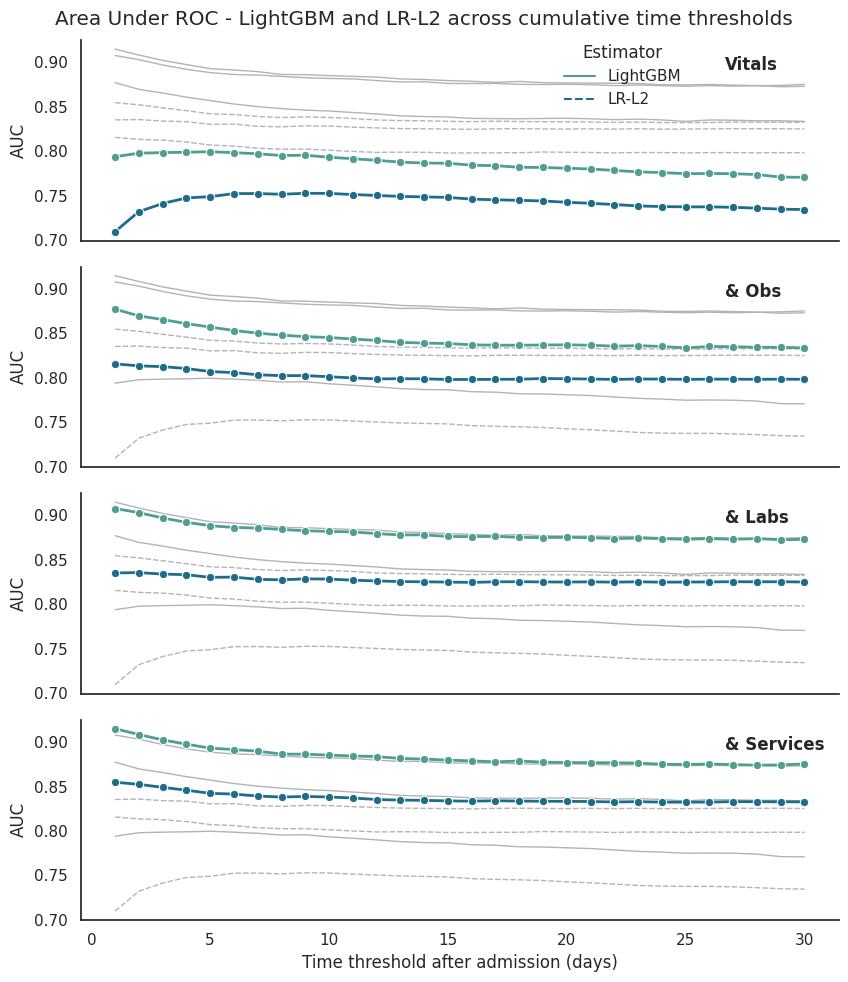

In [9]:
def timeseries_relplot(metrics, save=None):
    df = pd.Series(metrics.values(), index=metrics.keys(), name='AUC').reset_index().rename(columns={
        'level_0': 'Estimator',
        'level_1': 'Features',
        'level_2': 'Threshold'
    })
    df['Features'] = df.Features.map(PRETTY_PRINT_FEATURE_GROUPS.get)
    df['Estimator'] = df.Estimator.map(PRETTY_PRINT_ESTIMATORS.get)
    df = df[df.Threshold != 0]
    sns.set_theme(style="white")
    g = sns.relplot(
        data=df, x='Threshold', y='AUC', hue='Estimator', col='Features', marker='o',
        kind='line', palette='crest', linewidth=2, zorder=5, col_wrap=1, height=2.5, aspect=3.5
    )
    g.legend.legendHandles[1].set_linestyle('--')
    sns.move_legend(g, 'upper right', bbox_to_anchor=(0.7, 0.96), frameon=False)
    subp = [(i, features, ax) for i, (features, ax) in enumerate(g.axes_dict.items())]
    for i, features, ax in subp:
        ax.text(.85, .85, features, transform=ax.transAxes, fontweight='bold')
        line = sns.lineplot(
            data=df, x='Threshold', y='AUC', units='Features', style='Estimator', 
            estimator=None, color='.7', linewidth=1, ax=ax, legend=False
        )
    g.set_titles("")
    g.set_axis_labels("Time threshold after admission (days)", "AUC")
    g.tight_layout()
    g.fig.suptitle('Area Under ROC - LightGBM and LR-L2 across cumulative time thresholds', x=0.43)
    g.fig.subplots_adjust(top=0.95)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

    mask = (df.Estimator == 'LightGBM') & (df.Features=='Vitals')
    print(f'Vitals: {df[mask].AUC.max()} -> {df[mask].AUC.min()}')

timeseries_relplot(RESULTS_TIME, save=Notebook.IMAGE_DIR/'timeseries_auc.svg')

## Dataset

In [118]:
DATASET_VARIANTS = {
    'Total': SAL,
    'Train.': SAL.loc[SAL_TRAIN_IDX],
    'Valid. (Complete)': SAL.loc[SAL_TEST_IDX],
    'Valid. (Unseen)': SAL.loc[SAL_TEST_UNSEEN_IDX]
}

In [119]:
print(f'Total number of critical events: {SAL.derive_critical_event(within=9999, return_series=True).sum()}')

Total number of critical events: 11169


### Unseen Comparison

In [72]:
def compare_common_patients():
    sal, sal_train, sal_test = DATASET_VARIANTS['Total'], DATASET_VARIANTS['Train.'], DATASET_VARIANTS['Valid. (Complete)']
    num_common = np.isin(sal_train.PatientNumber.unique(), sal_test.PatientNumber.unique()).sum()
    total_patients = sal.PatientNumber.unique().shape[0]
    print(f'Patients appearing in both the train and test sets: {num_common} = {num_common/total_patients*100:.2f}%')

    num_episodes = sal_test.PatientNumber.isin(sal_train.PatientNumber.unique()).sum()
    print(f'Number of episodes by overlapping patients: {num_episodes} = {num_episodes/sal_test.shape[0]*100:.2f}%')

compare_common_patients()

Patients appearing in both the train and test sets: 7980 = 12.69%
Number of episodes by overlapping patients: 16613 = 41.30%


### Numerical Variables

In [75]:
from salford_datasets.salford import _generate_salford_feature_combinations

def summarise_numerical_variables():   
    feature_groups_non_cumulative = _generate_salford_feature_combinations()[0]
    feature_groups_to_present = {
        'Episode': ['TotalLOS', 'HasDNAR'],
        'Outcomes': ['DiedDuringStay', 'DiedWithin30Days', 'CriticalCare', 'CriticalEvent'],
        'Vitals': feature_groups_non_cumulative['news'],
        'Supplemental Obs. & Phenotype': feature_groups_non_cumulative['with_phenotype'],
        'Labs': feature_groups_non_cumulative['with_labs'],
        'Service Utilisation': feature_groups_non_cumulative['with_services'],
    }
    all_columns = [__ for _ in feature_groups_to_present.values() for __ in _]
    binary_columns = SAL[all_columns].select_dtypes(bool).columns
    numerical_columns = SAL[all_columns].select_dtypes('number').columns
    group_lookup = {
        column: group_name for group_name, columns in feature_groups_to_present.items() for column in columns
    }

    get_binary_summary = lambda col: f'{col.sum()} ({col.sum()/col.shape[0]*100:.2f}%)'.replace('.00', '')
    binary_summaries = [dict(
        Dataset=dataset_name,
        Variable=PRETTY_PRINT_FEATURE_NAMES[column_name],
        Group=group_lookup[column_name],
        Summary=get_binary_summary(df[column_name])
    ) for column_name in binary_columns for dataset_name, df in DATASET_VARIANTS.items()]

    get_numerical_summary = lambda col: f'{col.median():.2f} ({col.quantile(0.25):.2f}-{col.quantile(0.75):.2f})'.replace('.00','')
    numerical_summaries = [dict(
        Dataset=dataset_name,
        Variable=PRETTY_PRINT_FEATURE_NAMES[column_name],
        Group=group_lookup[column_name],
        Summary=get_numerical_summary(df[column_name])
    ) for column_name in numerical_columns for dataset_name, df in DATASET_VARIANTS.items()]
    numerical_summaries += [dict(
        Dataset=dataset_name,
        Variable='Records',
        Group='Episode',
        Summary=df.shape[0]
    ) for dataset_name, df in DATASET_VARIANTS.items()]
    numerical_summaries += [dict(
        Dataset=dataset_name,
        Variable='Patients',
        Group='Episode',
        Summary=df.PatientNumber.unique().shape[0]
    ) for dataset_name, df in DATASET_VARIANTS.items()]
    
    
    return pd.DataFrame(
        binary_summaries + numerical_summaries
    ).pivot(
        index=['Group', 'Variable'], 
        columns='Dataset', 
        values='Summary'
    ).loc[feature_groups_to_present.keys()][DATASET_VARIANTS.keys()]
    

dataset_numerical_summary_table = summarise_numerical_variables()
dataset_numerical_summary_table

Dataset                                                               Total  \
Group                         Variable                                        
Episode                       Has DNAR                       27869 (22.86%)   
                              Length of Stay               2.75 (0.73-7.97)   
                              Patients                                62889   
                              Records                                121892   
Outcomes                      Critical Care                     348 (0.29%)   
                              Critical Event                   5312 (4.36%)   
                              Died During Stay                 5742 (4.71%)   
                              Died Within 30 Days              4126 (3.38%)   
Vitals                        Assisted Breathing             16175 (13.27%)   
                              Heart Rate                         82 (71-92)   
                              O2 Sats                            97 (96-98)   
                              Respiratory Rate                   18 (16-19)   
                              Systolic Blood Pressure         126 (114-140)   
                              Temperature               36.70 (36.40-37.10)   
Supplemental Obs. & Phenotype Age                                68 (49-81)   
                              Charlson Index                        3 (1-4)   
                              Clinical Frailty Score                5 (4-6)   
                              Diastolic Blood Pressure           70 (60-80)   
                              Nausea                           2378 (1.95%)   
                              Sex                            63006 (51.69%)   
                              Vomiting                          794 (0.65%)   
                              Waterlow Score                       9 (5-13)   
Labs                          Albumin                            41 (38-45)   
                              C-Reactive Protein               19 (2.25-65)   
                              Creatinine                        78 (63-102)   
                              D-dimer                      252 (125-555.25)   
                              Haemoglobin                     131 (117-144)   
                              Potassium                    4.20 (3.90-4.50)   
                              Sodium                          138 (135-140)   
                              Urea                         6.30 (4.60-9.10)   
                              White Blood Cell Count         9.10 (7-12.20)   
Service Utilisation           Readmission                    12963 (10.63%)   
                              SDEC Allocation                24630 (20.21%)   

Dataset                                                              Train.  \
Group                         Variable                                        
Episode                       Has DNAR                       15447 (18.91%)   
                              Length of Stay               2.33 (0.67-7.13)   
                              Patients                                44947   
                              Records                                 81667   
Outcomes                      Critical Care                     241 (0.30%)   
                              Critical Event                   3552 (4.35%)   
                              Died During Stay                 3479 (4.26%)   
                              Died Within 30 Days              2711 (3.32%)   
Vitals                        Assisted Breathing             10163 (12.44%)   
                              Heart Rate                         81 (70-92)   
                              O2 Sats                            97 (96-98)   
                              Respiratory Rate                   18 (16-19)   
                              Systolic Blood Pressure         124 (112-140)   
                              Temperature        

In [77]:
#print(dataset_numerical_summary_table.to_latex(multirow=True, column_format='llrrrrr', bold_rows=True))

### Categorical Variables

In [87]:
def summarise_categorical_variables():
    categorical_columns = SAL[SalfordCombinations['with_services']].select_dtypes('category').columns
    
    categorical_summaries = []
    for dataset_name, df in DATASET_VARIANTS.items():
        for column_name in categorical_columns:
            value_counts = df[column_name].value_counts()
            tail_length = value_counts.shape[0]-6
            if tail_length > 0:
                tail = value_counts.tail(tail_length)
                value_counts['Other'] = tail.sum()
                value_counts = value_counts.drop(tail.index)

            
            categorical_summaries.append((
                value_counts.astype(str) + ' (' + (
                    (value_counts/df.shape[0]*100).round(2)
                ).astype(str)+ '%)').to_frame(name='Summary').reset_index()
                .assign(Dataset=dataset_name, Variable=PRETTY_PRINT_FEATURE_NAMES[column_name])
                .rename(columns=dict(index='Value')).to_dict(orient='records')
            )

    df = pd.DataFrame([__ for _ in categorical_summaries for __ in _])
    return df.pivot(
        index=['Variable', 'Value'],
        columns='Dataset',
        values='Summary'
    ).fillna('0 (0%)')[DATASET_VARIANTS.keys()]
    
dataset_categorical_summary_table = summarise_categorical_variables()
dataset_categorical_summary_table

Dataset                                                                 Total  \
Variable                  Value                                                 
Admission Pathway         EMERG TRAN OTH PROV                     325 (0.27%)   
                          EMERGENCY A+E                       114510 (93.94%)   
                          EMERGENCY GP REFER                     6253 (5.13%)   
                          EMERGENCY OPD                           637 (0.52%)   
                          NON EM TRAN OTH PROV                    167 (0.14%)   
Alertness Scale           A - Alert                           118794 (97.46%)   
                          C - New onset of confusion              920 (0.75%)   
                          P - Responds to pain                    416 (0.34%)   
                          U - Unconscious                         173 (0.14%)   
                          V - Responds to voice                   1587 (1.3%)   
Assisted Breathing Device A - AIR                             105717 (86.73%)   
                          N - NASAL CANNULA                     11681 (9.58%)   
                          Other                                  1246 (1.02%)   
                          RM - RESERVOIR MASK                     584 (0.48%)   
                          SM - SIMPLE MASK                       1448 (1.19%)   
                          V24 - VENTURI 24%                            0 (0%)   
                          V28 - VENTURI 28%                       518 (0.42%)   
                          V35 - VENTURI 35%                       451 (0.37%)   
                          V40 - VENTURI 40%                            0 (0%)   
Ethnicity                 AFRICAN (BLACK OR BLACK BRITISH)       1248 (1.02%)   
                          ANY OTHER ASIAN BACKGROUND                   0 (0%)   
                          ANY OTHER ETHNIC GROUP                 1007 (0.83%)   
                          ANY OTHER WHITE BACKGROUND             2820 (2.31%)   
                          Other                                  3456 (2.84%)   
                          PAKISTANI (ASIAN OR ASIAN BRITISH)     1024 (0.84%)   
                          WHITE BRITISH                       109687 (89.99%)   
                          WHITE IRISH                            2389 (1.96%)   
Pain Scale                0 - No pain                          98761 (81.02%)   
                          1 - Mild pain                          11947 (9.8%)   
                          2 - Moderate pain                      3326 (2.73%)   
                          3 - Severe pain                         594 (0.49%)   
Waterlow Outcome          10+ At Risk                            8449 (6.93%)   
                          10+ At risk                           18532 (15.2%)   
                          15+ High Risk                          4255 (3.49%)   
                          15+ High risk                          9586 (7.86%)   
                          20+ Very high risk                     4081 (3.35%)   
                          Below 10                             58129 (47.69%)   
                          Other                                   1825 (1.5%)   

Dataset                                                               Train.  \
Variable                  Value                                                
Admission Pathway         EMERG TRAN OTH PROV                    224 (0.27%)   
                          EMERGENCY A+E                       76775 (94.01%)   
                          EMERGENCY GP REFER                    4091 (5.01%)   
                          EMERGENCY OPD                           490 (0.6%)   
                          NON EM TRAN OTH PROV                    87 (0.11%)   
Alertness Scale           A - Alert                           79516 (97.37%)   
                          C - New onset of confusion             532 (0.65%)   
                          P - Responds 

In [91]:
#print(dataset_categorical_summary_table.to_latex(multirow=True, bold_rows=True, column_format='ll|rrrr'))

### Demographic Subgroups

In [127]:
SAL.Ethnicity.value_counts()

WHITE BRITISH                           109687
ANY OTHER WHITE BACKGROUND                2820
WHITE IRISH                               2389
AFRICAN (BLACK OR BLACK BRITISH)          1248
PAKISTANI (ASIAN OR ASIAN BRITISH)        1024
ANY OTHER ETHNIC GROUP                    1007
ANY OTHER ASIAN BACKGROUND                 991
INDIAN (ASIAN OR ASIAN BRITISH)            591
ANY OTHER BLACK BACKGROUND                 444
CHINESE (OTHER ETHNIC GROUPS)              343
CARIBBEAN (BLACK OR BLACK BRITISH)         296
ANY OTHER MIXED BACKGROUND                 244
BANGLADESHI (ASIAN OR ASIAN BRITISH)       175
WHITE AND BLACK CARIBBEAN (MIXED)          144
WHITE AND ASIAN (MIXED)                    120
WHITE AND BLACK AFRICAN (MIXED)            108
Name: Ethnicity, dtype: int64

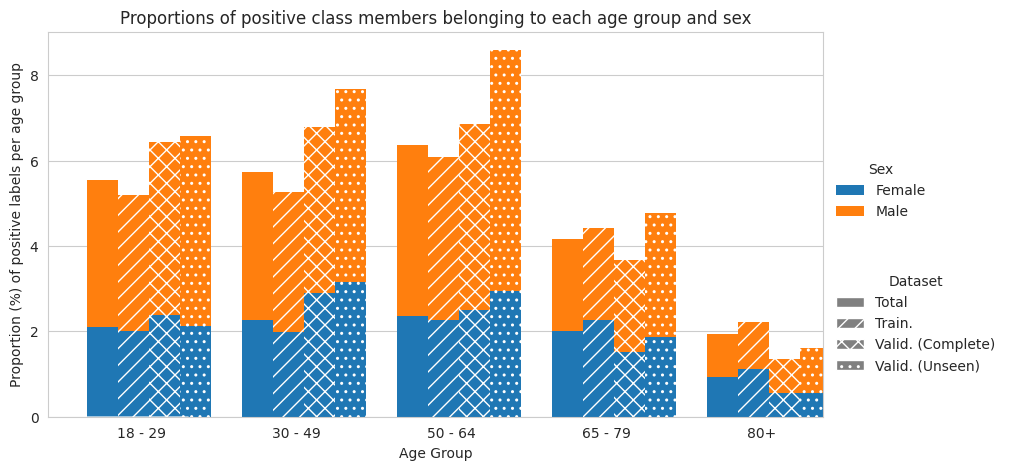

In [134]:
from transformer_experiment.utils.plots import plot_clustered_stacked

def demographics_barplot(save=None):
    fig, ax = plt.subplots(1,1, figsize=(10, 5))

    dfs = {}
    for dataset_name, df in DATASET_VARIANTS.items():
        df = df[['Female', 'Age', 'CriticalEvent']].copy()
        df['Female'] = df.Female.replace({True: "Female", False: "Male"})
        df['Age'] = SalfordData(df).derive_age_band(return_series=True)

        df = df.groupby(['Age', 'Female']).CriticalEvent.sum()/df.groupby(['Age']).CriticalEvent.count()*100
        df = df.reset_index().pivot(columns=['Female'], values=['CriticalEvent'], index='Age').CriticalEvent
        dfs[dataset_name] = df

    plot_clustered_stacked(list(dfs.values()), list(dfs.keys()), ['Sex', 'Dataset'], title='Proportions of positive class members belonging to each age group and sex')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Proportion (%) of positive labels per age group')
    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')


demographics_barplot(save=Notebook.IMAGE_DIR/'age_sex_bars.svg')

### Inclusion-Exclusion

In [22]:
def inclusion_exclusion_flow():
    df = pd.read_hdf(Notebook.DATA_DIR/'raw_v2.h5', 'table')
    df = SalfordData.from_raw(df, verbose=True)
    df = df.inclusion_exclusion_criteria(verbose=True)
    
inclusion_exclusion_flow()

Initial dataset size: 401650
Removed 2 patients without a valid NHS number or age: 401648
Removed 193 patients not discharged yet: 401455
Removed 35628 cases before Jan 1st 2015: 365827
Removed 1 records under 18 years old: 365826
Removed 71812 booked admissions, elective admissions, maternity, and trauma cases: 294014
Removed 72734 records without, at minimum, recorded NEWS: 221280
Removed 98013 records to limit cases to acute medical admissions: 123267
